# Goal

* Based on scRecounter cell counts and SRA metadata on dataset release dates, assess the cell counts over time for SRA

In [43]:
import os
from pathlib import Path
import pandas as pd
import plotnine as pn
from plotnine.scales.scale_color import scale_color_brewer
from pypika import Query, Table, functions as fn
from SRAgent.db.connect import db_connect
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)
pn.theme_set(pn.theme_bw())

In [44]:
# get base of github repo
base_dir = !git rev-parse --show-toplevel
base_dir = Path(base_dir[0])

In [45]:
# set number of columns to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)

In [46]:
def pandas_complete(df: pd.DataFrame, 
                    group_cols: list, 
                   fill_cols: dict = None, 
                   fill_value: float = 0) -> pd.DataFrame:
    """
    Equivalent of tidyr::complete - fills missing combinations of grouping variables.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    group_cols : list
        List of column names to create combinations from
    fill_cols : dict, optional
        Dictionary mapping column names to fill values for missing combinations.
        If None, all non-grouping columns will be filled with fill_value
    fill_value : float, default 0
        Default value to fill missing combinations with
        
    Returns:
    --------
    pd.DataFrame
        Complete dataframe with all combinations and filled values
        
    Example:
    --------
    # Fill missing combinations with 0 for 'count' column
    df_complete = pandas_complete(df, 
                                 group_cols=['year', 'category'], 
                                 fill_cols={'count': 0})
    
    # Fill all non-grouping columns with 0
    df_complete = pandas_complete(df, group_cols=['year', 'category'])
    """
    import itertools
    
    # Get unique values for each grouping column
    unique_values = [df[col].unique() for col in group_cols]
    
    # Create all possible combinations
    all_combinations = list(itertools.product(*unique_values))
    df_complete = pd.DataFrame(all_combinations, columns=group_cols)
    
    # Merge with original data
    df_merged = df_complete.merge(df, on=group_cols, how='left')
    
    # Fill missing values
    if fill_cols is None:
        # Fill all non-grouping columns with fill_value
        non_group_cols = [col for col in df_merged.columns if col not in group_cols]
        fill_dict = {col: fill_value for col in non_group_cols}
    else:
        fill_dict = fill_cols
    
    df_result = df_merged.fillna(fill_dict)
    
    return df_result


# Get release dates

In [47]:
# obtaining the release dates using the SRAgent utility script
exe = base_dir.parent / "SRAgent" / "scripts" / "get-srx-release-date.py"
!{exe} --help

usage: get-srx-release-date.py [-h] [--accessions ACCESSIONS [ACCESSIONS ...]]
                               [--use-db] [--output OUTPUT] [--limit LIMIT]
                               [--tenant {test,prod}]
                               [--batch-size BATCH_SIZE] [--retries RETRIES]

Obtain the release dates for SRA experiment accessions

options:
  -h, --help            show this help message and exit
  --accessions ACCESSIONS [ACCESSIONS ...]
                        SRX accessions to use; can be a CSV file with a
                        'srx_accession' column (default: None)
  --use-db              Use the database to get the SRX accessions (default:
                        False)
  --output OUTPUT       Output file name (default: srx_dates.csv)
  --limit LIMIT         Limit the number of records to process (default: None)
  --tenant {test,prod}  Database tenant to use (default: test)
  --batch-size BATCH_SIZE
                        Number of accessions to process per BigQuery bat

In [48]:
# run the script to get the release dates
#release_date_file = base_dir / "data" / "get-srx-date" / "2025-06-13_SRX-release-dates.csv"
#!{exe} --tenant prod --use-db --output {release_date_file}

In [49]:
# run the script to get the release dates
#release_date_file = base_dir / "data" / "get-srx-date" / "2025-07-09_SRX-release-dates_TMP.csv"
#!{exe} --tenant prod --accessions missing_release_date.csv --output {release_date_file}

In [50]:
# x =  base_dir / "data" / "get-srx-date" / "2025-06-13_SRX-release-dates.csv"
# y =  base_dir / "data" / "get-srx-date" / "2025-07-09_SRX-release-dates_TMP.csv"
# z = base_dir / "data" / "get-srx-date" / "2025-07-09_SRX-release-dates.csv"
# !cat {x} > {z} 
# !tail -n +2 {y} >> {z}

In [51]:
# read in the release dates
release_date_file = base_dir / "data" / "get-srx-date" / "2025-07-09_SRX-release-dates.csv.gz"
df_release_dates = pd.read_csv(release_date_file)
df_release_dates

,srx_accession,release_date
0,SRX7016897,2019-10-18
1,SRX7016896,2019-10-18
...,...,...
61420,NRX0000218,NaN
61421,NRX0000554,NaN


In [52]:
# number NaN for release_date
df_release_dates["release_date"].isna().sum()

818

# Get scRecounter cell counts 

In [53]:
# set tenant
os.environ["DYNACONF"] = "prod"

In [54]:
def get_screcounter_star_results(
    conn, 
    feature="GeneFull_Ex50pAS"
):
    """
    Get the screcounter_star_results table
    
    Args:
        conn: A database connection object (e.g., sqlite3, psycopg2, etc.)
        feature: String of the feature to filter on
    Returns:
        A pandas DataFrame of records
    """
    
    # Define tables
    meta_table = Table('srx_metadata')
    star_table = Table('screcounter_star_results')
    
    # Build the star query with feature filter (case insensitive)
    star_query = (
        Query.from_(star_table)
        .select('*')
        .where(
            fn.Lower(star_table.feature) == feature.lower()
        )
    )

    #return pd.read_sql_query(str(star_query), conn)
    
    # Build the main query with join
    # Assuming you want all columns from both tables except feature from star and _at columns from meta
    main_query = (
        Query.from_(star_table)
        .join(meta_table)
        .on(star_table.sample == meta_table.srx_accession)
        .select(
            star_table.sample.as_('srx_accession'),
            star_table.feature,
            star_table.estimated_number_of_cells,
            star_table.median_reads_per_cell,
            star_table.median_umi_per_cell,
            star_table.median_feature_per_cell,
            star_table.number_of_reads,
            meta_table.lib_prep,
            meta_table.tech_10x,
            meta_table.organism,
            meta_table.tissue,
            meta_table.tissue_ontology_term_id,
            meta_table.cell_prep
        )
        .where(
            fn.Lower(star_table.feature) == feature.lower()
        )
        .where(
            meta_table.lib_prep == "10x_Genomics"
        )
    )
    
    # Execute query and return as DataFrame
    return pd.read_sql_query(str(main_query), conn)

with db_connect() as conn:
    df_cells = get_screcounter_star_results(conn, feature="GeneFull_Ex50pAS")
df_cells

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep
0,SRX11379041,GeneFull_Ex50pAS,11712,1900.0,1298.0,706.0,928418782,10x_Genomics,3_prime_gex,Bos taurus,Intervertebral Disc (IVD),UBERON:0001066,single_cell
1,SRX22482811,GeneFull_Ex50pAS,4155,1558.0,985.0,677.0,213379400,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61379,NRX0000530,GeneFull_Ex50pAS,4623,1239.0,807.0,643.0,43957436,10x_Genomics,3_prime_gex,Callithrix jacchus,brain,UBERON:0000955,single_nucleus
61380,NRX0000531,GeneFull_Ex50pAS,7188,1077.0,844.0,684.0,42315726,10x_Genomics,3_prime_gex,Callithrix jacchus,brain,UBERON:0000955,single_nucleus


In [58]:
# sum by organism
pd.set_option('display.max_rows', 40)
df_cells.groupby("organism").agg({"estimated_number_of_cells": "sum"}).reset_index().sort_values("estimated_number_of_cells", ascending=False)

,organism,estimated_number_of_cells
12,Homo sapiens,302288515
16,Mus musculus,163687964
13,Macaca mulatta,9164160
5,Danio rerio,6399100
3,Callithrix jacchus,4742509
6,Drosophila melanogaster,3730277
24,Sus scrofa,2773996
0,Arabidopsis thaliana,1984986
21,Rattus norvegicus,1295798
1,Bos taurus,1194485


# Join

In [59]:
# merge the two dataframes
pd.set_option('display.max_rows', 4)
df_cells = df_cells.merge(df_release_dates, on="srx_accession", how="left")
df_cells

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date
0,SRX11379041,GeneFull_Ex50pAS,11712,1900.0,1298.0,706.0,928418782,10x_Genomics,3_prime_gex,Bos taurus,Intervertebral Disc (IVD),UBERON:0001066,single_cell,2021-10-08
1,SRX22482811,GeneFull_Ex50pAS,4155,1558.0,985.0,677.0,213379400,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,2023-12-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61420,NRX0000530,GeneFull_Ex50pAS,4623,1239.0,807.0,643.0,43957436,10x_Genomics,3_prime_gex,Callithrix jacchus,brain,UBERON:0000955,single_nucleus,NaN
61421,NRX0000531,GeneFull_Ex50pAS,7188,1077.0,844.0,684.0,42315726,10x_Genomics,3_prime_gex,Callithrix jacchus,brain,UBERON:0000955,single_nucleus,NaN


In [14]:
# missing release_date
df_cells["release_date"].isna().sum()

818

In [15]:
# format
## convert release_date to datetime
df_cells["release_date"] = pd.to_datetime(df_cells["release_date"])
## bin release date by month
df_cells["release_date_month"] = pd.to_datetime(df_cells["release_date"]).dt.to_period('M')
## bin release date by year
df_cells["release_date_year"] = pd.to_datetime(df_cells["release_date"]).dt.to_period('Y')
## change certain tech_10x labels to "other"
keep_tech_10x = ["3_prime_gex", "5_prime_gex", "multiome", "vdj", "feature_barcoding", "cellplex"]
df_cells["tech_10x"] = df_cells["tech_10x"].apply(lambda x: "other" if x not in keep_tech_10x else x)
# show 
df_cells

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date,release_date_month,release_date_year
0,SRX22482811,GeneFull_Ex50pAS,4155,1558.0,985.0,677.0,213379400,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,2023-12-13,2023-12,2023
1,SRX13824065,GeneFull_Ex50pAS,6348,20669.0,2371.0,1288.0,236554023,10x_Genomics,3_prime_gex,Mus musculus,skin,UBERON:0022295,single_cell,2022-12-31,2022-12,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61420,NRX0000735,GeneFull_Ex50pAS,7610,38152.0,16165.0,5640.0,642140441,10x_Genomics,3_prime_gex,Homo sapiens,neocortex,UBERON:0000955,single_nucleus,NaT,NaT,NaT
61421,NRX0000736,GeneFull_Ex50pAS,9545,29154.0,13508.0,5153.0,686955264,10x_Genomics,3_prime_gex,Homo sapiens,neocortex,UBERON:0000955,single_nucleus,NaT,NaT,NaT


In [16]:
# total cells
x = df_cells["estimated_number_of_cells"].sum()
print(f"Total cells: {x}")

Total cells: 502764327


In [17]:
# total reads in trillions
x = df_cells["number_of_reads"].sum() / 1e12
print(f"Total reads in trillions: {x:.1f}")

Total reads in trillions: 13.8


In [20]:
# sum by organism
pd.set_option('display.max_rows', None)
df_cells.groupby("organism").agg({"estimated_number_of_cells": "sum"}).reset_index().sort_values("estimated_number_of_cells", ascending=False)

,organism,estimated_number_of_cells
12,Homo sapiens,302437077
16,Mus musculus,163786913
13,Macaca mulatta,9164160
5,Danio rerio,6433477
3,Callithrix jacchus,4742509
6,Drosophila melanogaster,3730277
24,Sus scrofa,2773996
0,Arabidopsis thaliana,1984986
21,Rattus norvegicus,1295798
1,Bos taurus,1194485


# Summarize

## Culm cell count by year

### By tech_10x

In [21]:
# summarize cells by year and tech_10x
pd.set_option('display.max_rows', 4)
df_cells_sum = df_cells.groupby(["release_date_year", "tech_10x"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_sum

,release_date_year,tech_10x,estimated_number_of_cells
0,2018,other,1853
1,2019,3_prime_gex,353318
...,...,...,...
43,2025,other,3249787
44,2025,vdj,146838


In [22]:
# Check: sum the number of cells
df_cells_sum["estimated_number_of_cells"].sum()

497726918

In [23]:
# sum by tech_10x
pd.set_option('display.max_rows', 10)
df_cells_sum_tech = df_cells.groupby(["tech_10x"]).agg({"estimated_number_of_cells": "sum"}).reset_index().sort_values(by="estimated_number_of_cells", ascending=False)
df_cells_sum_tech

,tech_10x,estimated_number_of_cells
0,3_prime_gex,387170007
1,5_prime_gex,69159929
5,other,20934193
4,multiome,11933028
3,feature_barcoding,9847542
6,vdj,3250170
2,cellplex,469458


In [24]:
# fraction that is 3_prime_gex
prime3 = df_cells_sum_tech[df_cells_sum_tech["tech_10x"] == "3_prime_gex"].reset_index().loc[0,"estimated_number_of_cells"]
total = df_cells_sum_tech["estimated_number_of_cells"].sum()
print(f"fraction 3_prime_gex: ({prime3 / total:.2%})")

fraction 3_prime_gex: (77.01%)


In [25]:
# amount of 5' for the past 2 years
target_years =[pd.Period('2024', freq='Y-DEC'), pd.Period('2025', freq='Y-DEC')]
df_cells_sum_tech = df_cells_sum[df_cells_sum["release_date_year"].isin(target_years)].groupby(["tech_10x"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
prime5 = df_cells_sum_tech[df_cells_sum_tech["tech_10x"] == "5_prime_gex"].reset_index().loc[0,"estimated_number_of_cells"]
total = df_cells_sum_tech["estimated_number_of_cells"].sum()
print(f"fraction 5_prime_gex for 2024-2025: ({prime5 / total:.2%})")

fraction 5_prime_gex for 2024-2025: (17.42%)


In [26]:
# expand the table
pd.set_option('display.max_rows', 4)
df_cells_sum = pandas_complete(
    df_cells_sum, 
    group_cols=["release_date_year", "tech_10x"]
)
df_cells_sum

,release_date_year,tech_10x,estimated_number_of_cells
0,2018,other,1853.0
1,2018,3_prime_gex,0.0
...,...,...,...
54,2025,vdj,146838.0
55,2025,cellplex,30986.0


In [27]:
# calculate cumsum
df = (
    df_cells_sum
    .sort_values(['tech_10x', 'release_date_year'])  # Ensure proper ordering
    .groupby('tech_10x')['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_sum = df.merge(
    df_cells_sum[['release_date_year', 'tech_10x']], 
    left_index=True, 
    right_index=True
)
df_cells_sum 

,estimated_number_of_cells,release_date_year,tech_10x
1,0.0,2018,3_prime_gex
8,353318.0,2019,3_prime_gex
...,...,...,...
47,3103332.0,2024,vdj
54,3250170.0,2025,vdj


In [28]:
# add total number of cells to the table
df = df_cells_sum.groupby(["release_date_year"]).sum().reset_index()
df["tech_10x"] = "Total"
df_cells_sum = pd.concat([df_cells_sum, df])
df_cells_sum

,estimated_number_of_cells,release_date_year,tech_10x
1,0.0,2018,3_prime_gex
8,353318.0,2019,3_prime_gex
...,...,...,...
6,441864351.0,2024,Total
7,497726918.0,2025,Total


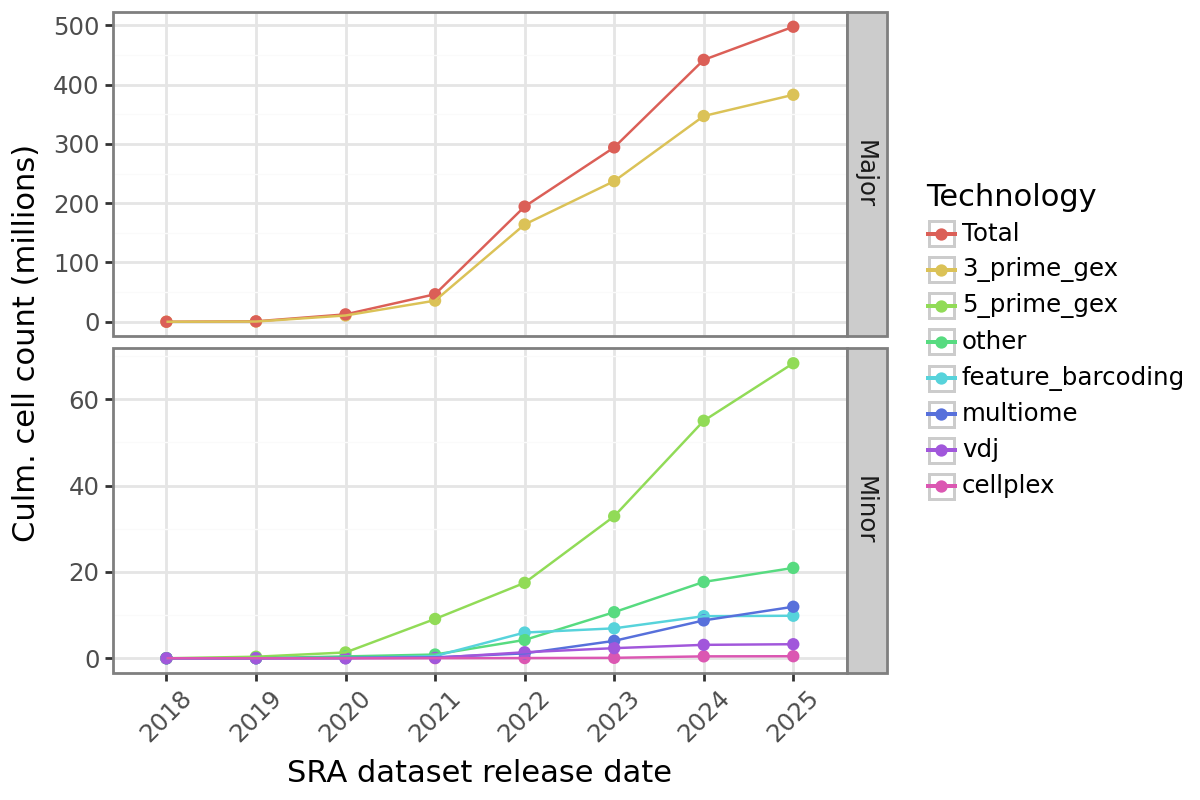

In [29]:
color_dict = {
    'Total': '#000000',
    '3_prime_gex': '#1f77b4',
    '5_prime_gex': '#ff7f0e', 
    'atac': '#2ca02c',
    'cellplex': '#d62728',
    'feature_barcoding': '#9467bd',
    'fixed_rna': '#8c564b',
    'flex': '#e377c2',
    'multiome': '#7f7f7f',
    'other': '#bcbd22',
    'vdj': '#17becf'
}

# copy for editing
df = df_cells_sum.copy()

# order by tech_10x
df_cnt_sum = df.groupby("tech_10x").agg({"estimated_number_of_cells": "sum"}).reset_index().sort_values("estimated_number_of_cells", ascending=False)
tech_10x_order = df_cnt_sum["tech_10x"].unique().tolist()
df["tech_10x"] = pd.Categorical(df["tech_10x"], categories=tech_10x_order)

df["facet"] = df["tech_10x"].apply(lambda x: "Major" if x in ["Total", "3_prime_gex"] else "Minor")
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tech_10x")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tech_10x")) +
    #pn.scale_y_log10() +
    pn.facet_grid("facet ~ .", scales="free_y") +
    # pn.scale_color_manual(
    #     values=color_dict,
    # ) +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Technology",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    )
)
p

In [30]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tech.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tech.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tech.svg


In [31]:
# save csv
outfile = base_dir / "figures" / "data" / "sra_cells-by-time_tech.csv"
df_cells_sum.to_csv(outfile, index=False)

### By tech_10x and lib_prep

In [32]:
group_cols = ["release_date_year", "tech_10x", "cell_prep"]

In [33]:
# summarize cells by groups
df_cells_sum = df_cells.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_sum

,release_date_year,tech_10x,cell_prep,estimated_number_of_cells
0,2018,other,single_nucleus,1853
1,2019,3_prime_gex,single_cell,353318
...,...,...,...,...
82,2025,other,single_nucleus,198368
83,2025,vdj,single_cell,146838


In [34]:
# complete the table
df_cells_sum = pandas_complete(
    df_cells_sum, 
    group_cols=["release_date_year", "tech_10x", "cell_prep"]
)
df_cells_sum

,release_date_year,tech_10x,cell_prep,estimated_number_of_cells
0,2018,other,single_nucleus,1853.0
1,2018,other,single_cell,0.0
...,...,...,...,...
222,2025,cellplex,unsure,0.0
223,2025,cellplex,not_applicable,0.0


In [35]:
# calculate cumsum
df = (
    df_cells_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_sum = df.merge(
    df_cells_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_sum 

,estimated_number_of_cells,release_date_year,tech_10x,cell_prep
7,0.0,2018,3_prime_gex,not_applicable
5,0.0,2018,3_prime_gex,single_cell
...,...,...,...,...
216,0.0,2025,vdj,single_nucleus
218,0.0,2025,vdj,unsure


In [36]:
# add total number of cells to the table
df = df_cells_sum.groupby(["release_date_year", "cell_prep"]).sum().reset_index()
df["tech_10x"] = "Total"
df_cells_sum = pd.concat([df_cells_sum, df])
df_cells_sum

,estimated_number_of_cells,release_date_year,tech_10x,cell_prep
7,0.0,2018,3_prime_gex,not_applicable
5,0.0,2018,3_prime_gex,single_cell
...,...,...,...,...
30,37187529.0,2025,Total,single_nucleus
31,1015882.0,2025,Total,unsure


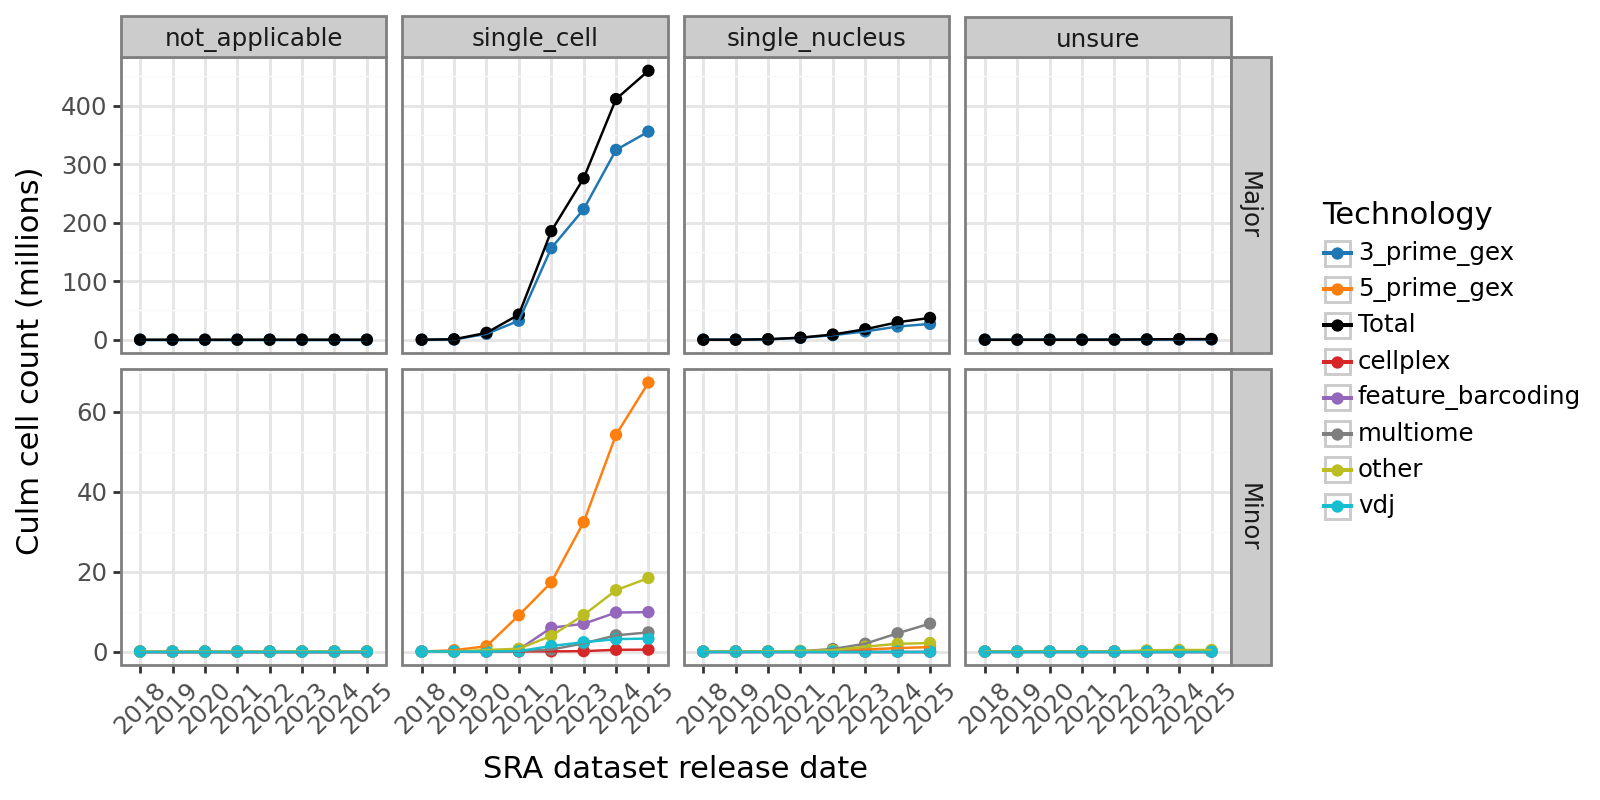

In [37]:
color_dict = {
    'Total': '#000000',
    '3_prime_gex': '#1f77b4',
    '5_prime_gex': '#ff7f0e', 
    'atac': '#2ca02c',
    'cellplex': '#d62728',
    'feature_barcoding': '#9467bd',
    'fixed_rna': '#8c564b',
    'flex': '#e377c2',
    'multiome': '#7f7f7f',
    'other': '#bcbd22',
    'vdj': '#17becf'
}

df = df_cells_sum.copy()
df["facet"] = df["tech_10x"].apply(lambda x: "Major" if x in ["Total", "3_prime_gex"] else "Minor")
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tech_10x")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tech_10x")) +
    #pn.scale_y_log10() +
    pn.facet_grid("facet ~ cell_prep", scales="free_y") +
    pn.scale_color_manual(
        values=color_dict,
    ) +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm cell count (millions)",
        color = "Technology",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(8, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    )
)
p

### By organism

In [38]:
# summarize cells by year and tech_10x
df_cells_sum = df_cells.groupby(["release_date_year", "organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_sum

,release_date_year,organism,estimated_number_of_cells
0,2018,Mus musculus,1853
1,2019,Homo sapiens,590436
...,...,...,...
107,2025,Solanum lycopersicum,10877
108,2025,Sus scrofa,439317


In [42]:
# sum by organism across all years
df_cells_sum_organism = df_cells_sum.groupby(["organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
pd.set_option('display.max_rows', 40)
df_cells_sum_organism.sort_values("estimated_number_of_cells", ascending=False)

,organism,estimated_number_of_cells
12,Homo sapiens,300487352
16,Mus musculus,163589015
13,Macaca mulatta,9164160
5,Danio rerio,6364723
6,Drosophila melanogaster,3730277
24,Sus scrofa,2773996
0,Arabidopsis thaliana,1984986
3,Callithrix jacchus,1921477
21,Rattus norvegicus,1295798
1,Bos taurus,1194485


In [ ]:
# % human
pd.set_option('display.max_rows', 4)
human = df_cells_sum_organism[df_cells_sum_organism["organism"] == "Homo sapiens"].reset_index().loc[0,"estimated_number_of_cells"]
total = df_cells_sum_organism["estimated_number_of_cells"].sum()
print(f"fraction human: ({human / total:.2%})")

fraction human: (60.37%)


In [41]:
# % mouse
mouse = df_cells_sum_organism[df_cells_sum_organism["organism"] == "Mus musculus"].reset_index().loc[0,"estimated_number_of_cells"]
total = df_cells_sum_organism["estimated_number_of_cells"].sum()
print(f"fraction mouse: ({mouse / total:.2%})")

fraction mouse: (32.87%)


In [38]:
# calculate the % increase for each organism from 2022 to 2025
## 2022
target_years =[pd.Period('2022', freq='Y-DEC')]
df_cells_sum_organism_2022 = df_cells_sum[df_cells_sum["release_date_year"].isin(target_years)].groupby(["organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
#df_cells_sum_organism_2022["release_date_year"] = "2022"
df_cells_sum_organism_2022["estimated_number_of_cells"] = df_cells_sum_organism_2022["estimated_number_of_cells"] / df_cells_sum_organism_2022["estimated_number_of_cells"].sum() * 100

## 2025
target_years =[pd.Period('2025', freq='Y-DEC')]
df_cells_sum_organism_2025 = df_cells_sum[df_cells_sum["release_date_year"].isin(target_years)].groupby(["organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
#df_cells_sum_organism_2025["release_date_year"] = "2025"
df_cells_sum_organism_2025["estimated_number_of_cells"] = df_cells_sum_organism_2025["estimated_number_of_cells"] / df_cells_sum_organism_2025["estimated_number_of_cells"].sum() * 100

## merge
df_cells_sum_organism_2022_2025 = pd.merge(df_cells_sum_organism_2022, df_cells_sum_organism_2025, on="organism", how="inner", suffixes=("_2022", "_2025"))
df_cells_sum_organism_2022_2025["delta_perc_cells"] = df_cells_sum_organism_2022_2025["estimated_number_of_cells_2025"] - df_cells_sum_organism_2022_2025["estimated_number_of_cells_2022"]
pd.set_option('display.max_rows', 30)
df_cells_sum_organism_2022_2025.sort_values(by="delta_perc_cells", ascending=False)


,organism,estimated_number_of_cells_2022,estimated_number_of_cells_2025,delta_perc_cells
9,Mus musculus,16.819798,41.169438,24.349640
8,Macaca mulatta,1.113180,2.081286,0.968106
11,Ovis aries,0.090320,0.950551,0.860231
14,Sus scrofa,0.146526,0.786425,0.639898
13,Rattus norvegicus,0.161350,0.781543,0.620193
4,Danio rerio,0.714024,1.143571,0.429547
3,Callithrix jacchus,0.366840,0.673347,0.306507
1,Bos taurus,0.170427,0.396298,0.225871
6,Gallus gallus,0.136166,0.294736,0.158570
5,Drosophila melanogaster,0.537700,0.652340,0.114641


In [39]:
# complete the table
pd.set_option('display.max_rows', 4)
df_cells_sum = pandas_complete(
    df_cells_sum, 
    group_cols=["release_date_year", "organism"]
)
df_cells_sum

,release_date_year,organism,estimated_number_of_cells
0,2018,Mus musculus,1853.0
1,2018,Homo sapiens,0.0
...,...,...,...
214,2025,Gasterosteus aculeatus,79256.0
215,2025,Monodelphis domestica,33337.0


In [40]:
# calculate cumsum
df = (
    df_cells_sum
    .sort_values(['organism', 'release_date_year'])  # Ensure proper ordering
    .groupby('organism')['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_sum = df.merge(
    df_cells_sum[['release_date_year', 'organism']], 
    left_index=True, 
    right_index=True
)
df_cells_sum 

,estimated_number_of_cells,release_date_year,organism
13,0.0,2018,Arabidopsis thaliana
40,0.0,2019,Arabidopsis thaliana
...,...,...,...
174,279544.0,2024,Zea mays
201,279544.0,2025,Zea mays


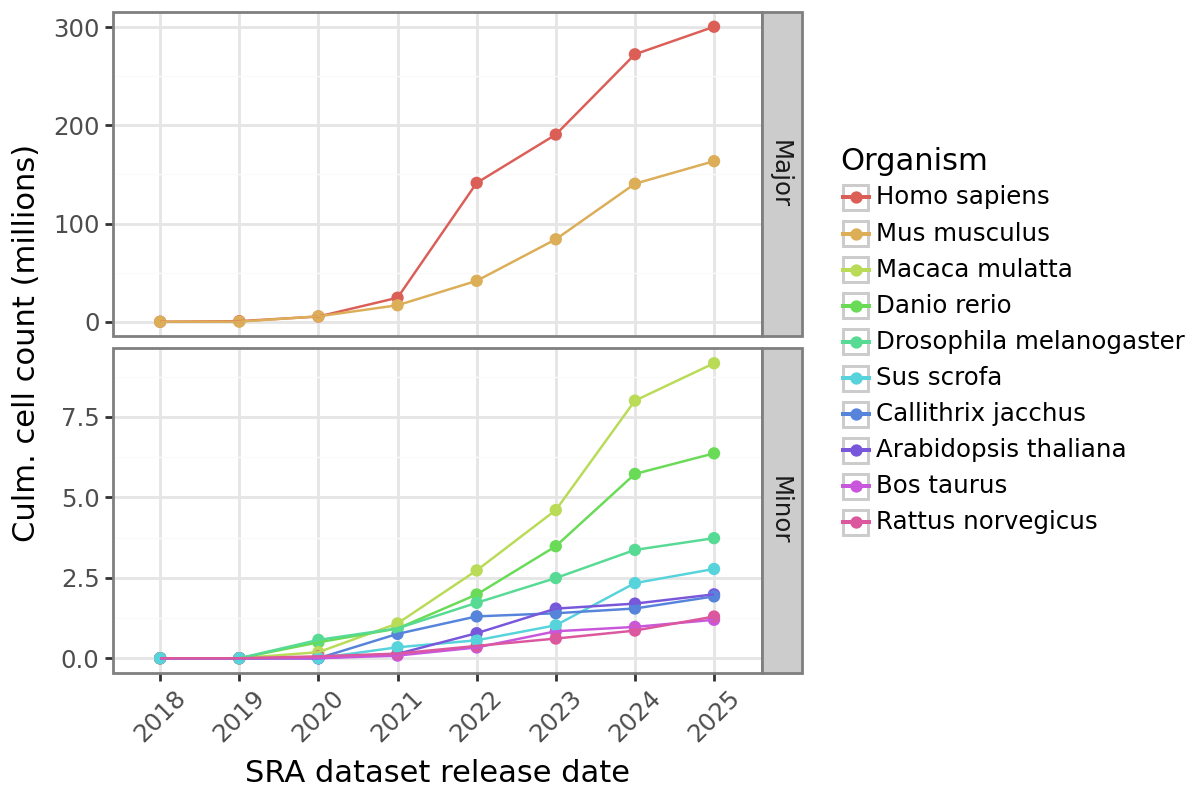

In [41]:
df = df_cells_sum.copy()

# filter to top10 organisms by total cell count
df_top10 = df.groupby("organism").agg({"estimated_number_of_cells": "sum"}).reset_index().sort_values("estimated_number_of_cells", ascending=False).head(10)
df = df[df["organism"].isin(df_top10["organism"])]

# order by organism
organism_order = df_top10["organism"].tolist()
df["organism"] = pd.Categorical(df["organism"], categories=organism_order)

# add facet
df["facet"] = df["organism"].apply(lambda x: "Major" if x in ["Homo sapiens", "Mus musculus"] else "Minor")
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="organism")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="organism")) +
    pn.facet_grid("facet ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Organism",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  
    )
)
p

In [34]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_organism.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_organism.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_organism.svg


In [42]:
# save csv
outfile = base_dir / "figures" / "data" / "sra_cells-by-time_organism.csv"
df_cells_sum.to_csv(outfile, index=False)

### By tissue

In [44]:
# load CellxGene tissue categories
df_tissue_cats = pd.read_csv(base_dir / "data" / "tissues" / "2025-06-30_tissue_categories.csv.gz")
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
...,...,...
15543,zebrafish larval intestines,intestine
15544,zebrafish marrow,bone marrow


In [ ]:
# merge tissue categories
df_cells_tissues = df_cells.merge(df_tissue_cats, left_on="tissue", right_on="tissue", how="left").rename(columns={"category": "tissue_category"})
df_cells_tissues["tissue_category"] = df_cells_tissues["tissue_category"].apply(lambda x: "other" if pd.isna(x) else x)
df_cells_tissues

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date,release_date_month,release_date_year,tissue_category
0,SRX22482811,GeneFull_Ex50pAS,4155,1558.0,985.0,677.0,213379400,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,2023-12-13,2023-12,2023,blood
1,SRX13824065,GeneFull_Ex50pAS,6348,20669.0,2371.0,1288.0,236554023,10x_Genomics,3_prime_gex,Mus musculus,skin,UBERON:0022295,single_cell,2022-12-31,2022-12,2022,skin of body
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61420,NRX0000507,GeneFull_Ex50pAS,4672,1217.0,743.0,601.0,43802145,10x_Genomics,3_prime_gex,Callithrix jacchus,brain,UBERON:0000955,single_nucleus,NaT,NaT,NaT,brain
61421,NRX0000508,GeneFull_Ex50pAS,15345,4436.0,3006.0,1931.0,426950817,10x_Genomics,3_prime_gex,Callithrix jacchus,brain,UBERON:0000955,single_nucleus,NaT,NaT,NaT,brain


In [ ]:
# set group columns
group_cols = ["release_date_year", "tissue_category"]

In [47]:
# summarize cells by groups
df_cells_tissues_sum = df_cells_tissues.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_tissues_sum

,release_date_year,tissue_category,estimated_number_of_cells
0,2018,kidney,1853
1,2019,adipose tissue,4971
...,...,...,...
385,2025,vasculature,801080
386,2025,yolk sac,93321


In [48]:
# compete the table
df_cells_tissues_sum = pandas_complete(
    df_cells_tissues_sum, 
    group_cols=["release_date_year", "tissue_category"]
)
df_cells_tissues_sum

,release_date_year,tissue_category,estimated_number_of_cells
0,2018,kidney,1853.0
1,2018,adipose tissue,0.0
...,...,...,...
582,2025,seed,0.0
583,2025,seedling,0.0


In [49]:
# calculate cumsum
df = (
    df_cells_tissues_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_tissues_sum = df.merge(
    df_cells_tissues_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_tissues_sum 

,estimated_number_of_cells,release_date_year,tissue_category
13,0.0,2018,abdomen
1,0.0,2018,adipose tissue
...,...,...,...
562,6477248.0,2025,vasculature
578,182268.0,2025,yolk sac


In [50]:
# # add total number of cells to the table
# df = df_cells_tissues_sum.groupby(["release_date_year"]).sum().reset_index()
# df["tech_10x"] = "Total"
# df_cells_tissues_sum = pd.concat([df_cells_tissues_sum, df])
# df_cells_tissues_sum

/tmp/ipykernel_3918233/2690258807.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3918233/2690258807.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


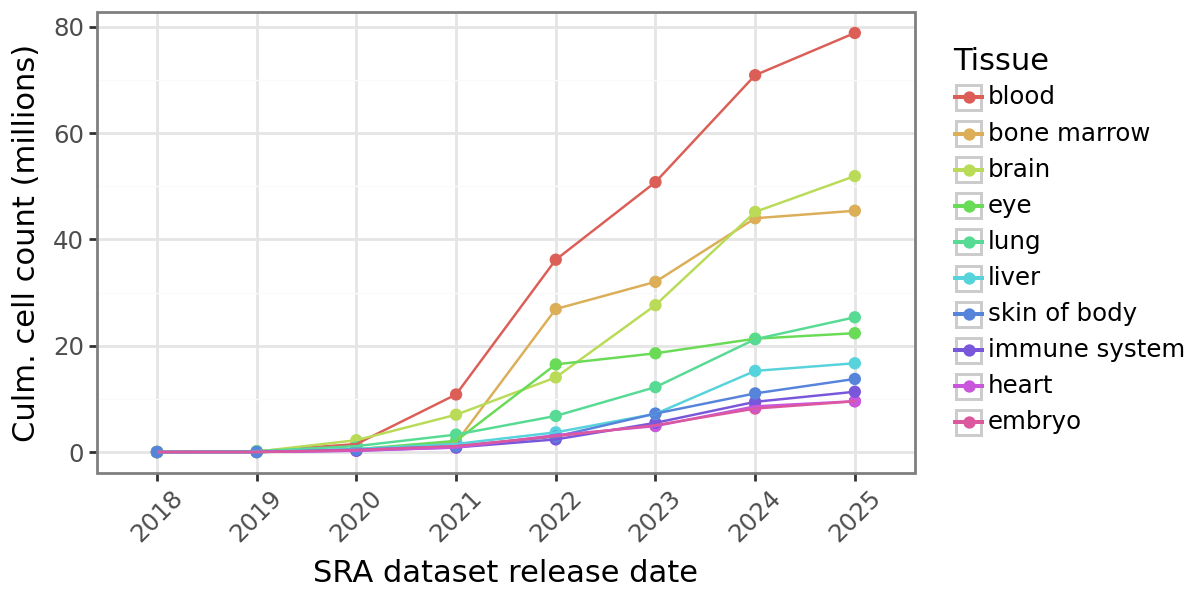

In [51]:
# filter to top 10 tissues
df_cells_tissues_sum_top10 = (
    df_cells_tissues_sum[["tissue_category", "estimated_number_of_cells"]][df_cells_tissues_sum["tissue_category"] != "other"]
    .groupby("tissue_category").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_tissues_sum[df_cells_tissues_sum["tissue_category"].isin(df_cells_tissues_sum_top10["tissue_category"])]

# order by count
tissue_order = df_cells_tissues_sum_top10["tissue_category"].unique().tolist()
df["tissue_category"] = pd.Categorical(df["tissue_category"], categories=tissue_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    #pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 3),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [43]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues.svg


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 3 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues.svg


In [52]:
# save csv
outfile = base_dir / "figures" / "data" / "sra_cells-by-time_tissues.csv"
df_cells_tissues_sum.to_csv(outfile, index=False)

### tissues for human and mouse

In [53]:
group_cols = ["release_date_year", "tissue_category", "organism"]

In [54]:
# summarize cells by groups
df_cells_tissues_sum = df_cells_tissues.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2018,kidney,Mus musculus,1853
1,2019,adipose tissue,Mus musculus,4971
...,...,...,...,...
1096,2025,yolk sac,Macaca mulatta,67206
1097,2025,yolk sac,Mus musculus,26115


In [55]:
# filter to just human and mouse
target_organisms = ["Homo sapiens", "Mus musculus"]
df_cells_tissues_sum = df_cells_tissues_sum[df_cells_tissues_sum["organism"].isin(target_organisms)]
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2018,kidney,Mus musculus,1853
1,2019,adipose tissue,Mus musculus,4971
...,...,...,...,...
1094,2025,vasculature,Mus musculus,330365
1097,2025,yolk sac,Mus musculus,26115


In [56]:
# compete
df_cells_tissues_sum = pandas_complete(
    df_cells_tissues_sum, 
    group_cols=["release_date_year", "tissue_category", "organism"]
)
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2018,kidney,Mus musculus,1853.0
1,2018,kidney,Homo sapiens,0.0
...,...,...,...,...
1086,2025,flower,Mus musculus,0.0
1087,2025,flower,Homo sapiens,0.0


In [57]:
# calculate cumsum
df = (
    df_cells_tissues_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_tissues_sum = df.merge(
    df_cells_tissues_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_tissues_sum 

,estimated_number_of_cells,release_date_year,tissue_category,organism
95,0.0,2018,abdomen,Homo sapiens
94,0.0,2018,abdomen,Mus musculus
...,...,...,...,...
1079,24227.0,2025,yolk sac,Homo sapiens
1078,90835.0,2025,yolk sac,Mus musculus


/tmp/ipykernel_3918233/2383468987.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3918233/2383468987.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


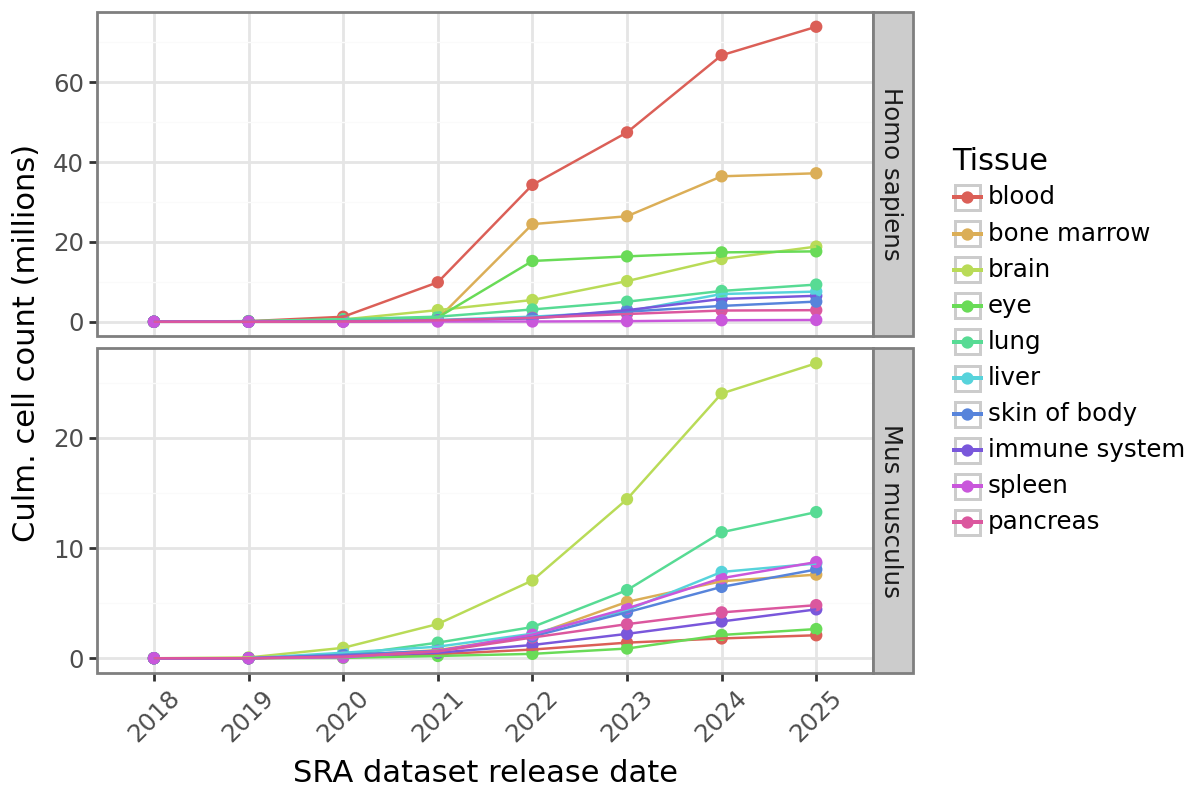

In [58]:
# filter to top 10 tissues
df_cells_tissues_sum_top10 = (
    df_cells_tissues_sum[["tissue_category", "estimated_number_of_cells"]][df_cells_tissues_sum["tissue_category"] != "other"]
    .groupby("tissue_category").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_tissues_sum[df_cells_tissues_sum["tissue_category"].isin(df_cells_tissues_sum_top10["tissue_category"])]

# order by count
tissue_order = df_cells_tissues_sum_top10["tissue_category"].unique().tolist()
df["tissue_category"] = pd.Categorical(df["tissue_category"], categories=tissue_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    pn.facet_grid("organism ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [50]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues_hm.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues_hm.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues_hm.svg


In [59]:
# save csv
outfile = base_dir / "figures" / "data" / "sra_cells-by-time_tissues_hm.csv"
df_cells_tissues_sum.to_csv(outfile, index=False)

In [51]:
# check on cell counts per organism/tissue
df = df_cells_tissues[(df_cells_tissues["organism"].isin(["Homo sapiens", "Mus musculus"])) & (df_cells_tissues["tissue"] == "blood")]
df = df.groupby(["organism", "tissue_category"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df

,organism,tissue_category,estimated_number_of_cells
0,Homo sapiens,blood,10524163
1,Mus musculus,blood,753087


## By tissue and tech_10x

In [60]:
# load CellxGene tissue categories
df_tissue_cats = pd.read_csv(base_dir / "data" / "tissues" / "2025-06-30_tissue_categories.csv.gz")
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
...,...,...
15543,zebrafish larval intestines,intestine
15544,zebrafish marrow,bone marrow


In [61]:
# merge with tissue categories
df_cells_tissues = df_cells.merge(df_tissue_cats, left_on="tissue", right_on="tissue", how="left").rename(columns={"category": "tissue_category"})
df_cells_tissues["tissue_category"] = df_cells_tissues["tissue_category"].apply(lambda x: "other" if pd.isna(x) else x)
df_cells_tissues

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date,release_date_month,release_date_year,tissue_category
0,SRX22482811,GeneFull_Ex50pAS,4155,1558.0,985.0,677.0,213379400,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,2023-12-13,2023-12,2023,blood
1,SRX13824065,GeneFull_Ex50pAS,6348,20669.0,2371.0,1288.0,236554023,10x_Genomics,3_prime_gex,Mus musculus,skin,UBERON:0022295,single_cell,2022-12-31,2022-12,2022,skin of body
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61420,NRX0000507,GeneFull_Ex50pAS,4672,1217.0,743.0,601.0,43802145,10x_Genomics,3_prime_gex,Callithrix jacchus,brain,UBERON:0000955,single_nucleus,NaT,NaT,NaT,brain
61421,NRX0000508,GeneFull_Ex50pAS,15345,4436.0,3006.0,1931.0,426950817,10x_Genomics,3_prime_gex,Callithrix jacchus,brain,UBERON:0000955,single_nucleus,NaT,NaT,NaT,brain


In [62]:
# select groups
group_cols = ["release_date_year", "tissue_category", "tech_10x"]

In [63]:
# summarize cells by groups
df_cells_tissues_sum = df_cells_tissues.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_tissues_sum

,release_date_year,tissue_category,tech_10x,estimated_number_of_cells
0,2018,kidney,other,1853
1,2019,adipose tissue,3_prime_gex,4971
...,...,...,...,...
1009,2025,vasculature,other,40890
1010,2025,yolk sac,3_prime_gex,93321


In [64]:
# add zeros via pandas_complete
df_cells_tissues_sum = pandas_complete(
    df_cells_tissues_sum, 
    group_cols=group_cols, 
    fill_cols={"estimated_number_of_cells": 0}
)
df_cells_tissues_sum

,release_date_year,tissue_category,tech_10x,estimated_number_of_cells
0,2018,kidney,other,1853.0
1,2018,kidney,3_prime_gex,0.0
...,...,...,...,...
4086,2025,seedling,vdj,0.0
4087,2025,seedling,cellplex,0.0


In [65]:
# calculate cumsum
df = (
    df_cells_tissues_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_tissues_sum = df.merge(
    df_cells_tissues_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_tissues_sum 

,estimated_number_of_cells,release_date_year,tissue_category,tech_10x
92,0.0,2018,abdomen,3_prime_gex
93,0.0,2018,abdomen,5_prime_gex
...,...,...,...,...
4046,0.0,2025,yolk sac,other
4051,0.0,2025,yolk sac,vdj


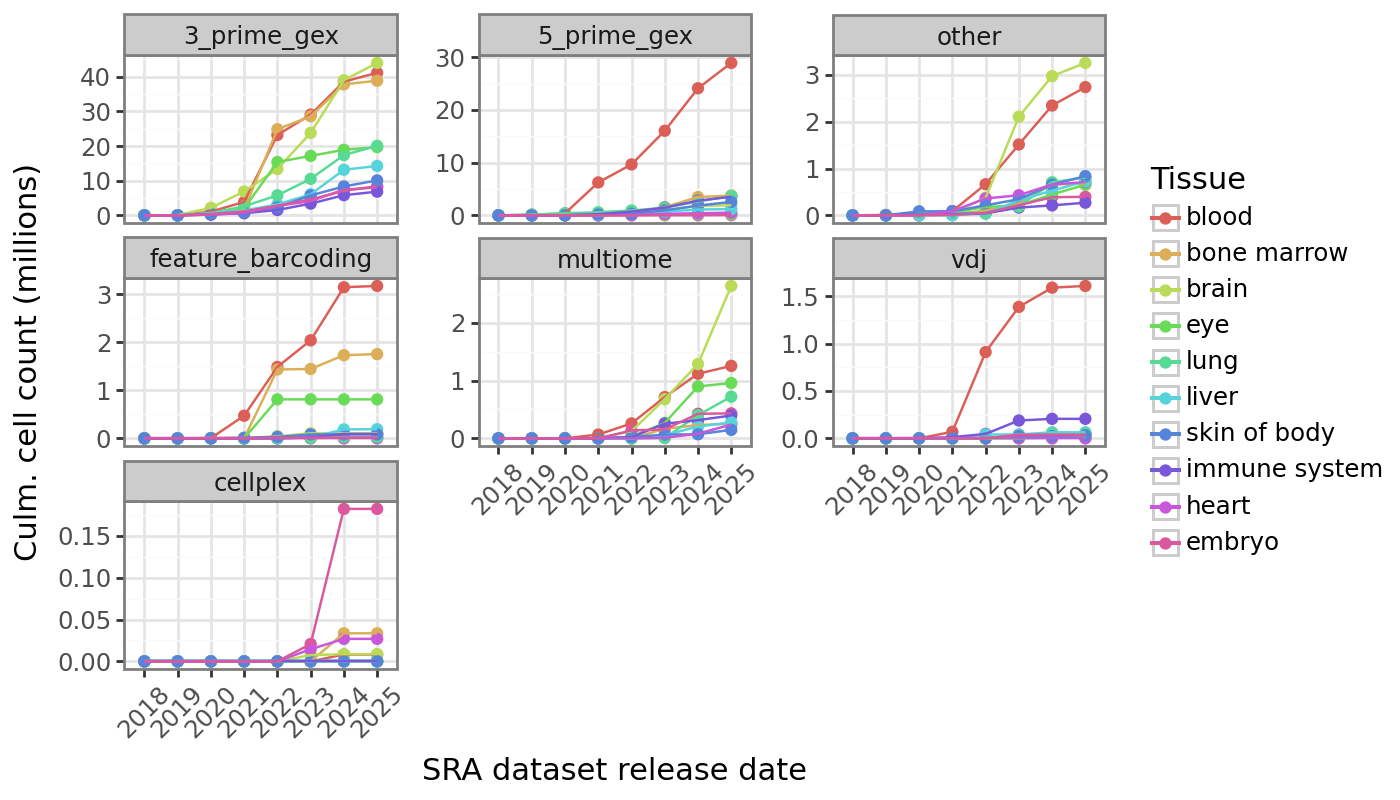

In [66]:
# filter to top 10 tissues
df_cells_tissues_sum_top10 = (
    df_cells_tissues_sum[["tissue_category", "tech_10x", "estimated_number_of_cells"]][df_cells_tissues_sum["tissue_category"] != "other"]
    .groupby("tissue_category").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_tissues_sum[df_cells_tissues_sum["tissue_category"].isin(df_cells_tissues_sum_top10["tissue_category"])]

# filter to top N tech_10x
# df_cells_tissues_sum_top10_tech = (
#     df_cells_tissues_sum[["tech_10x", "estimated_number_of_cells"]]
#     .groupby("tech_10x").sum()
#     .sort_values("estimated_number_of_cells", ascending=False)
#     .head(7)
#     .reset_index()
# )
# df = df[df["tech_10x"].isin(df_cells_tissues_sum_top10_tech["tech_10x"])]

# filter out fixed_rna
df = df[df["tech_10x"] != "fixed_rna"]

# order by sum of tech_10x by setting tech_10x as Categorical 
df_sum = df.groupby("tech_10x").agg({"estimated_number_of_cells": "sum"}).sort_values("estimated_number_of_cells", ascending=False).reset_index()
df["tech_10x"] = pd.Categorical(df["tech_10x"], categories=df_sum["tech_10x"].tolist())

# order by count
tissue_order = df_cells_tissues_sum_top10["tissue_category"].unique().tolist()
df["tissue_category"] = pd.Categorical(df["tissue_category"], categories=tissue_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6


# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    pn.facet_wrap("tech_10x", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(7, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [59]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues-tech.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues-tech.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues-tech.svg


In [67]:
# save as csv
outfile = base_dir / "figures" / "data" / "sra_cells-by-time_tech-tissue.csv"
df_cells_tissues_sum.to_csv(outfile, index=False)

#### Just top 6

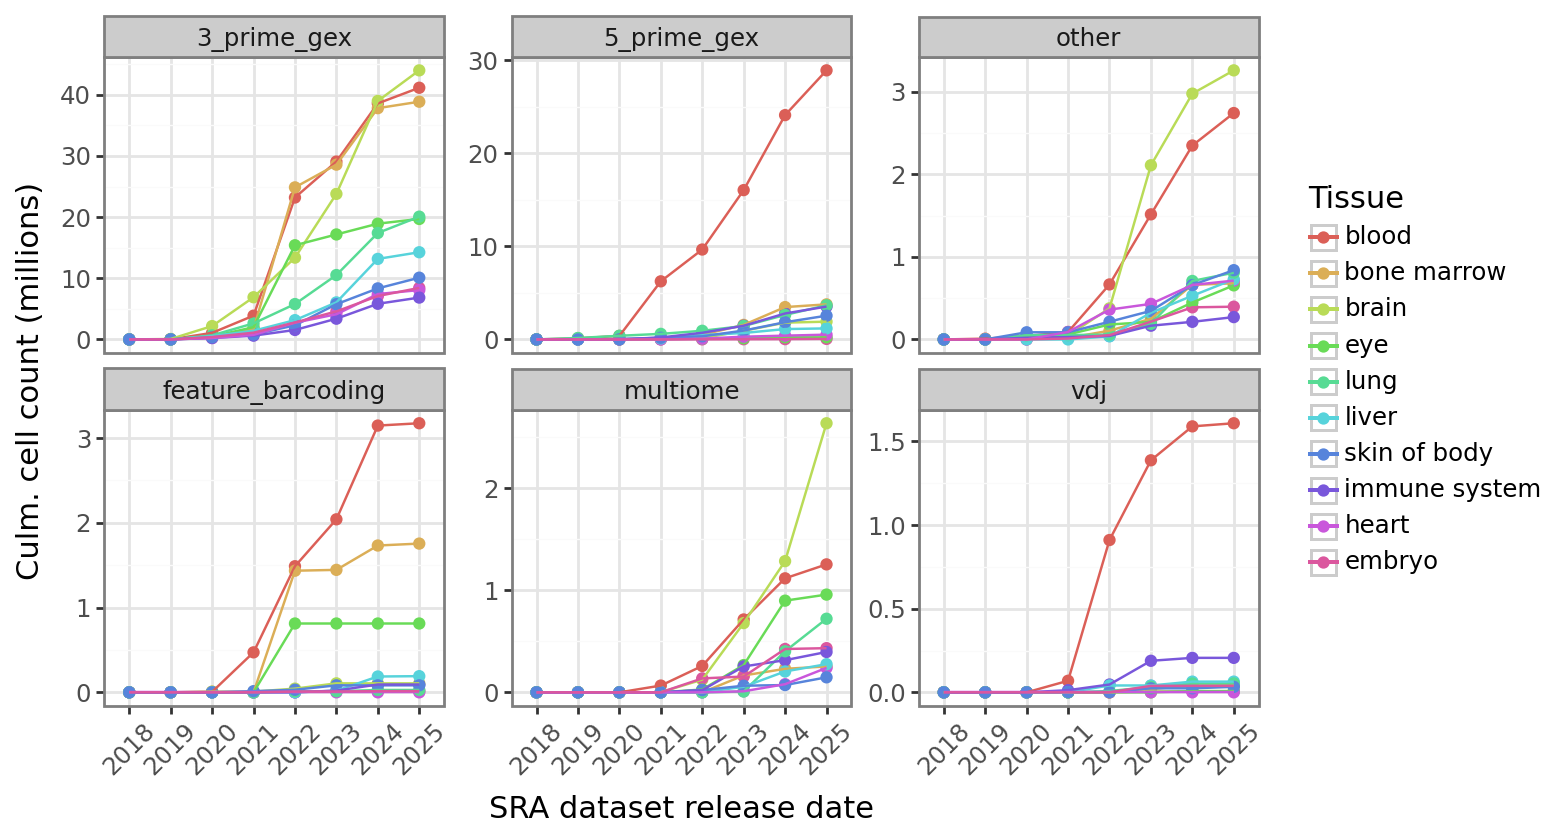

In [68]:
x = ["3_prime_gex", "5_prime_gex", "other", "feature_barcoding", "multiome", "vdj"]

# plot the number of cells over time
p = (
    pn.ggplot(
        df[df["tech_10x"].isin(x)], 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    pn.facet_wrap("tech_10x", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(7.8, 4.2),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [69]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_tissues-tech_top6.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7.8 x 4.2 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues-tech_top6.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues-tech_top6.svg


### Tissues for human and mouse

In [70]:
group_cols = ["release_date_year", "tissue_category", "organism"]

In [71]:
# summarize cells by groups
df_cells_tissues_sum = df_cells_tissues.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2018,kidney,Mus musculus,1853
1,2019,adipose tissue,Mus musculus,4971
...,...,...,...,...
1096,2025,yolk sac,Macaca mulatta,67206
1097,2025,yolk sac,Mus musculus,26115


In [72]:
# filter to just human and mouse
target_organisms = ["Homo sapiens", "Mus musculus"]
df_cells_tissues_sum = df_cells_tissues_sum[df_cells_tissues_sum["organism"].isin(target_organisms)]
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2018,kidney,Mus musculus,1853
1,2019,adipose tissue,Mus musculus,4971
...,...,...,...,...
1094,2025,vasculature,Mus musculus,330365
1097,2025,yolk sac,Mus musculus,26115


In [73]:
# get complete table
df_cells_tissues_sum = pandas_complete(
    df_cells_tissues_sum, 
    group_cols=["release_date_year", "tissue_category", "organism"]
)
df_cells_tissues_sum

,release_date_year,tissue_category,organism,estimated_number_of_cells
0,2018,kidney,Mus musculus,1853.0
1,2018,kidney,Homo sapiens,0.0
...,...,...,...,...
1086,2025,flower,Mus musculus,0.0
1087,2025,flower,Homo sapiens,0.0


In [74]:
# calculate cumsum
df = (
    df_cells_tissues_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_tissues_sum = df.merge(
    df_cells_tissues_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_tissues_sum 

,estimated_number_of_cells,release_date_year,tissue_category,organism
95,0.0,2018,abdomen,Homo sapiens
94,0.0,2018,abdomen,Mus musculus
...,...,...,...,...
1079,24227.0,2025,yolk sac,Homo sapiens
1078,90835.0,2025,yolk sac,Mus musculus


/tmp/ipykernel_3918233/2383468987.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3918233/2383468987.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


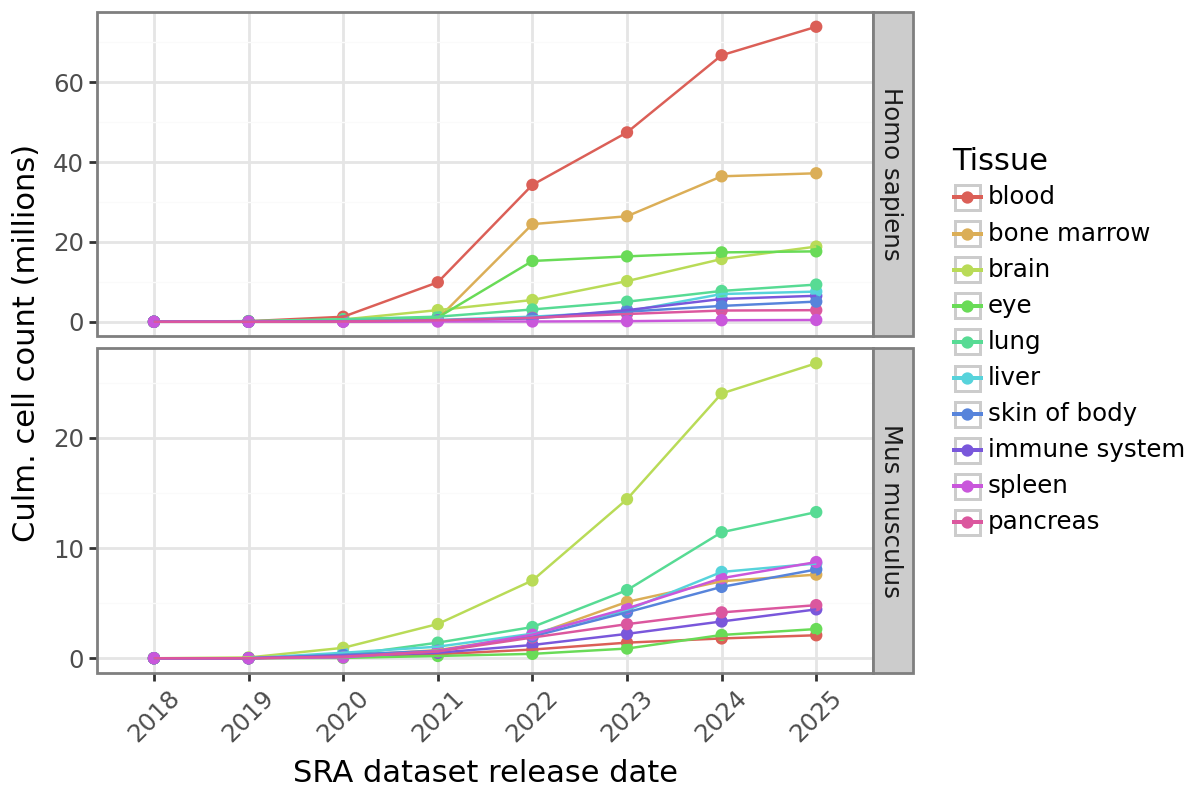

In [75]:
# filter to top 10 tissues
df_cells_tissues_sum_top10 = (
    df_cells_tissues_sum[["tissue_category", "estimated_number_of_cells"]][df_cells_tissues_sum["tissue_category"] != "other"]
    .groupby("tissue_category").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_tissues_sum[df_cells_tissues_sum["tissue_category"].isin(df_cells_tissues_sum_top10["tissue_category"])]

# order by count
tissue_order = df_cells_tissues_sum_top10["tissue_category"].unique().tolist()
df["tissue_category"] = pd.Categorical(df["tissue_category"], categories=tissue_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="tissue_category")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="tissue_category")) +
    pn.facet_grid("organism ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Tissue",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [ ]:
# # save as svg
# outfile = base_dir / "figures" / "sra_cells-by-time_tissues_hm.svg"
# pn.ggsave(p, outfile)
# print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues_hm.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_tissues_hm.svg


In [69]:
# check on cell counts per organism/tissue
df = df_cells_tissues[(df_cells_tissues["organism"].isin(["Homo sapiens", "Mus musculus"])) & (df_cells_tissues["tissue"] == "blood")]
df = df.groupby(["organism", "tissue_category"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
df

,organism,tissue_category,estimated_number_of_cells
0,Homo sapiens,blood,10524163
1,Mus musculus,blood,753087


## By disease for human and mouse

### Chris' disease categories

In [76]:
pd.set_option('display.max_rows', 4)
infile = '/large_storage/ctc/public/scBasecamp/SRA_Agent_metadata.parquet'
df_disease = pd.read_parquet(infile)[["srx_accession", "disease group", "disease_tag"]].rename({"disease group": "disease_group"}, axis=1)
df_disease

,srx_accession,disease_group,disease_tag
0,SRX5444597,Healthy,unclassified
1,SRX5822385,Healthy,none
...,...,...,...
134940,SRX29323945,Cancer,cancer
134942,SRX29351873,Healthy,none


In [77]:
# merge disease data
df_cells_disease = df_cells.merge(df_disease, on="srx_accession", how="inner")
# filter to mouse/humna
df_cells_disease = df_cells_disease[df_cells_disease["organism"].isin(["Mus musculus", "Homo sapiens"])]
# status
df_cells_disease

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date,release_date_month,release_date_year,disease_group,disease_tag
0,SRX22482811,GeneFull_Ex50pAS,4155,1558.0,985.0,677.0,213379400,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,single_cell,2023-12-13,2023-12,2023,Healthy,unclassified
1,SRX13824065,GeneFull_Ex50pAS,6348,20669.0,2371.0,1288.0,236554023,10x_Genomics,3_prime_gex,Mus musculus,skin,UBERON:0022295,single_cell,2022-12-31,2022-12,2022,Healthy,unclassified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60727,SRX29351873,GeneFull_Ex50pAS,6088,36348.0,20182.0,5557.0,532948341,10x_Genomics,multiome,Mus musculus,mouse embryonic stem cell nuclei,,single_nucleus,2025-06-25,2025-06,2025,Healthy,none
60728,SRX28122834,GeneFull_Ex50pAS,10048,35856.0,22023.0,5246.0,536264585,10x_Genomics,3_prime_gex,Mus musculus,epiphyseal chondrocytes (from long bones of hi...,UBERON:0002516,single_cell,2025-06-25,2025-06,2025,Healthy,none


In [78]:
# grouping columns
group_cols = ["release_date_year", "disease_group"]

In [79]:
# summarize cells by groups
df_cells_disease_sum = df_cells_disease.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_disease_sum

,release_date_year,disease_group,estimated_number_of_cells
0,2019,Cancer,13468
1,2019,Diabetes/Kidney disease,2283
...,...,...,...
62,2025,Ovarian/Uteral cancer,402184
63,2025,Viral infection,2141707


In [80]:
# compete
df_cells_disease_sum = pandas_complete(
    df_cells_disease_sum, 
    group_cols=group_cols
)
df_cells_disease_sum

,release_date_year,disease_group,estimated_number_of_cells
0,2019,Cancer,13468.0
1,2019,Diabetes/Kidney disease,2283.0
...,...,...,...
68,2025,Nervous System disorder,3915396.0
69,2025,Ovarian/Uteral cancer,402184.0


In [81]:
# calculate cumsum
df = (
    df_cells_disease_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_disease_sum = df.merge(
    df_cells_disease_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_disease_sum 

,estimated_number_of_cells,release_date_year,disease_group
4,0.0,2019,Ageing disease
5,0.0,2019,Blood cancer
...,...,...,...
69,3777807.0,2025,Ovarian/Uteral cancer
63,29460126.0,2025,Viral infection


In [83]:
# # filter to top 10 tissues
# df_cells_disease_sum_top10 = (
#     df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
#     .groupby("disease_group").sum()
#     .sort_values("estimated_number_of_cells", ascending=False)
#     .head(10)
#     .reset_index()
# )
# df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# # order by count
# disease_order = df_jcells_disease_sum_top10["disease_group"].unique().tolist()
# df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order)

# # format
# df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# # plot the number of cells over time
# p = (
#     pn.ggplot(
#         df, 
#         pn.aes(x="release_date_year", y="estimated_number_of_cells", color="disease_group")
#     ) +
#     pn.geom_point() +
#     pn.geom_line(pn.aes(group="disease_group")) +
#     #pn.facet_grid("organism ~ .", scales="free_y") +
#     pn.labs(
#         x = "SRA dataset release date",
#         y = "Culm. cell count (millions)",
#         color = "Disease",
#     ) +
#     pn.theme_bw() +
#     pn.theme(
#         figure_size=(5.2, 3.4),
#         axis_text_x=pn.element_text(angle=45, hjust=0.95),
#         legend_key_size=11,  # Reduce legend key size (default is around 20)
#     ) + 
#     pn.guides(
#         color=pn.guide_legend(ncol=1)
#     )
# )
# p

In [ ]:
# # save as svg
# outfile = base_dir / "figures" / "sra_cells-by-time_disease_hm.svg"
# pn.ggsave(p, outfile)
# print(f"File written to {outfile}")

File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm.svg


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5.2 x 3.4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm.svg


In [26]:
# append row for total cell count
df_total = []
for release_date_year in df_cells_disease_sum["release_date_year"].unique():
    total_cells = df_cells_disease_sum[df_cells_disease_sum["release_date_year"] == release_date_year]["estimated_number_of_cells"].sum() / 1e6
    df_total.append({"release_date_year": release_date_year, "disease_group": "Total", "estimated_number_of_cells": total_cells})

df_total = pd.DataFrame(df_total)
df_j = pd.concat([df, df_total])
df_j

,estimated_number_of_cells,release_date_year,disease_group
4,0.000000,2019,Ageing disease
5,0.000000,2019,Blood cancer
...,...,...,...
5,415.794240,2024,Total
6,467.004755,2025,Total


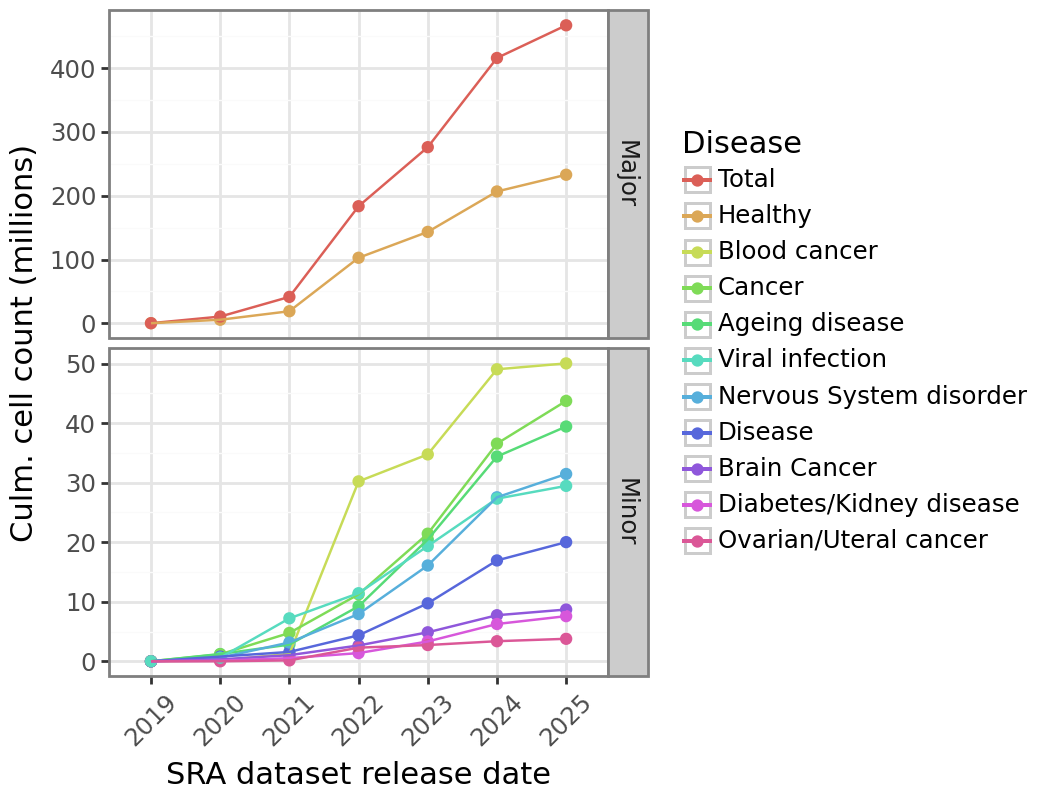

In [27]:
# a grouping columns: "Healthy" vs other
df_j["group"] = df_j["disease_group"].apply(lambda x: "Major" if x in ["Healthy", "Total"] else "Minor")

# move "Total" to the of start the category for Disease
disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
disease_order.insert(0, "Total")
df_j["disease_group"] = pd.Categorical(df_j["disease_group"], categories=disease_order, ordered=True)

# plot the number of cells over time
p = (
    pn.ggplot(
        df_j, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="disease_group")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="disease_group")) +
    pn.scale_color_discrete() + 
    pn.facet_grid("group ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Disease",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(5.2, 4),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11, 
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [28]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_disease_hm_total.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5.2 x 4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm_total.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm_total.svg


#### Disease rates

In [29]:
group_cols = ["release_date_year", "disease_group"]

In [30]:
# summarize cells by groups
df_cells_disease_sum = df_cells_disease.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_disease_sum

,release_date_year,disease_group,estimated_number_of_cells
0,2019,Cancer,13468
1,2019,Diabetes/Kidney disease,2283
...,...,...,...
62,2025,Ovarian/Uteral cancer,402184
63,2025,Viral infection,2141707


In [31]:
# compete
df_cells_disease_sum = pandas_complete(
    df_cells_disease_sum, 
    group_cols=group_cols
)
df_cells_disease_sum

,release_date_year,disease_group,estimated_number_of_cells
0,2019,Cancer,13468.0
1,2019,Diabetes/Kidney disease,2283.0
...,...,...,...
68,2025,Nervous System disorder,3915396.0
69,2025,Ovarian/Uteral cancer,402184.0


In [32]:
# total sum scaling per year
df_total = df_cells_disease_sum.groupby("release_date_year").agg({"estimated_number_of_cells": "sum"}).reset_index().rename(columns={"estimated_number_of_cells" : "total_cell_count"})
df_cells_disease_sum = df_cells_disease_sum.merge(df_total, on="release_date_year", how="inner")
df_cells_disease_sum["estimated_number_of_cells"] = df_cells_disease_sum["estimated_number_of_cells"] / df_cells_disease_sum["total_cell_count"]
df_cells_disease_sum["estimated_number_of_cells"].describe()

count    70.000000
mean      0.100000
           ...    
75%       0.099382
max       0.898821
Name: estimated_number_of_cells, Length: 8, dtype: float64

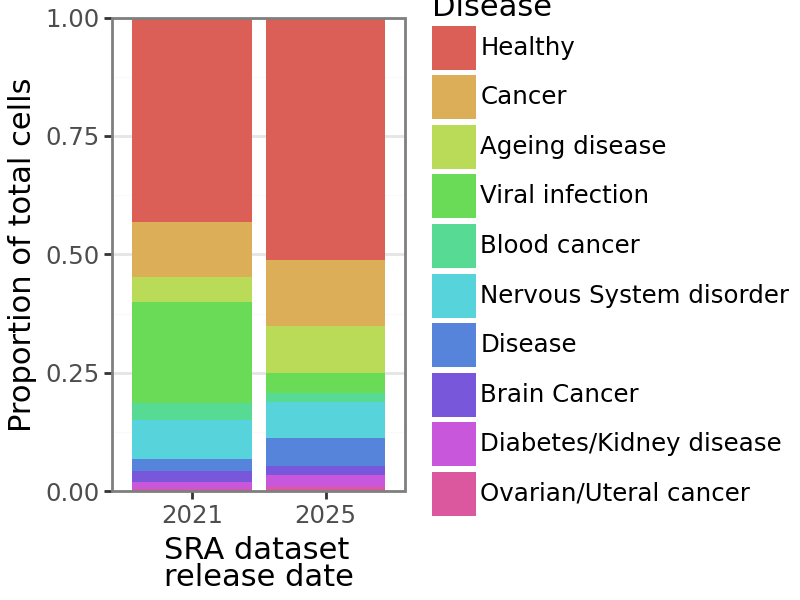

In [33]:
# plot the proportion of cells for 2021 and 2025
# filter to top 10 diseases
df_cells_disease_sum_top10 = (
    df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
    .groupby("disease_group").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# order by count
disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order)

# filter to 2021 and 2025
x = pd.PeriodIndex(['2021', '2025'], freq='Y-DEC')
df_2022 = df[df["release_date_year"].isin(x)]

# plot the proportion of cells for 2021 and 2025
p = (
    pn.ggplot(df_2022, pn.aes(x="release_date_year", y="estimated_number_of_cells", fill="disease_group")) +
    pn.geom_col() +
    pn.scale_y_continuous(expand=(0, 0)) +
    pn.labs(
        x = "SRA dataset\nrelease date",
        y = "Proportion of total cells",
        fill = "Disease",
    ) +
    pn.theme(
        figure_size=(4, 3),
        #legend_position="none",
    )
)
p

In [34]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_disease_hm_2021-2025.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm_2021-2025.svg


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 3 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm_2021-2025.svg


In [35]:
# calculate pct_change
df_cells_disease_sum['pct_change'] = (
    df_cells_disease_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .pct_change() * 100
)
x = pd.PeriodIndex(['2022', '2023', '2024', '2025'], freq='Y-DEC')
df_cells_disease_sum = df_cells_disease_sum[df_cells_disease_sum["release_date_year"].isin(x)]
df_cells_disease_sum["pct_change"].describe()

count     40.000000
mean      36.552678
            ...    
75%       79.804533
max      469.693500
Name: pct_change, Length: 8, dtype: float64

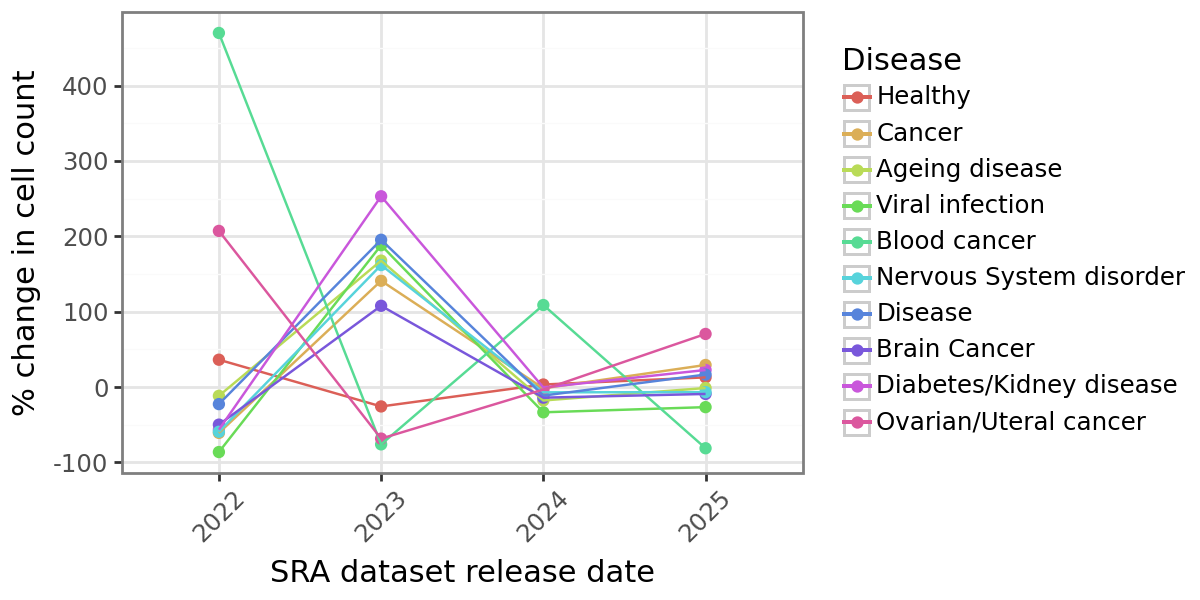

In [36]:
# filter to top 10 diseases
df_cells_disease_sum_top10 = (
    df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
    .groupby("disease_group").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# order by count
#disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order)

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="pct_change", color="disease_group")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="disease_group")) +
    pn.labs(
        x = "SRA dataset release date",
        y = "% change in cell count",
        color = "Disease",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 3),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

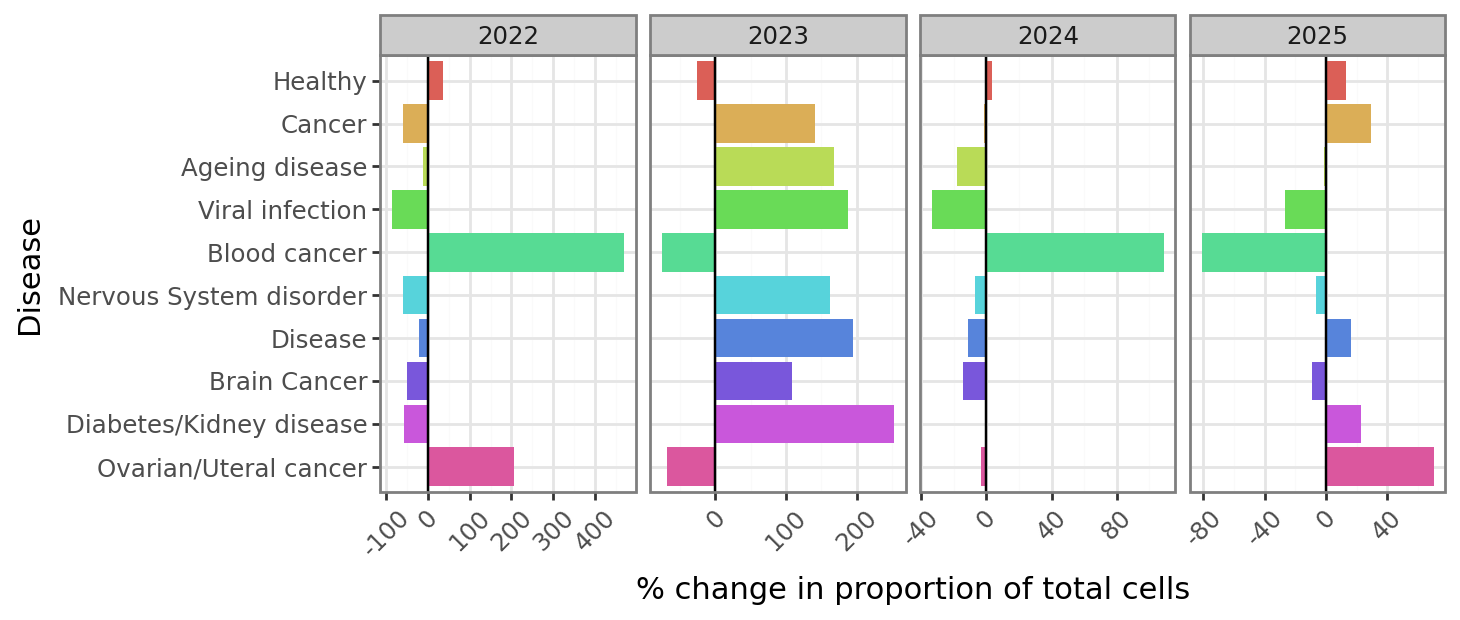

In [37]:
# filter to top 10 diseases
df_cells_disease_sum_top10 = (
    df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
    .groupby("disease_group").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(10)
    .reset_index()
)
df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# set color mapping
color_mapping = dict(zip(disease_order, pn.scale_color_discrete().palette(len(disease_order))))

# order by count
#disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order[::-1])

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="disease_group", y="pct_change", fill="disease_group")
    ) +
    pn.geom_col() +
    pn.geom_hline(pn.aes(yintercept=0), color="black") +
    pn.scale_fill_manual(values=color_mapping) +
    pn.facet_grid(". ~ release_date_year", scales="free_x") +
    pn.labs(
        x = "Disease",
        y = "% change in proportion of total cells",
        fill = "Direction",
    ) +
    pn.coord_flip() +
    pn.theme_bw() +
    pn.theme(
        figure_size=(7.3, 3.1),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
        legend_position="none",
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [38]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_disease_hm_pct-change.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7.3 x 3.1 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm_pct-change.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease_hm_pct-change.svg


### MONDO disease categories

In [84]:
pd.set_option('display.max_rows', 4)
infile = base_dir / "data" / "diseases" / "2025-07-22_scBaseCount_unique-diseases-with-ontology_sum_clst-n12_records.csv"
df_disease = pd.read_csv(infile).rename(columns={"mondo_cluster_name": "disease_group"})[["srx_accession", "disease_group"]]
df_disease

,srx_accession,disease_group
0,SRX23808188,Cancers and Oncology
1,SRX18313025,Cancers and Oncology
...,...,...
26775,ERX9138823,Neurological and Neurodegenerative
26776,ERX11760603,Cancers and Oncology


In [85]:
# merge disease data
df_cells_disease = df_cells.merge(df_disease, on="srx_accession", how="inner")
# filter to mouse/humna
df_cells_disease = df_cells_disease[df_cells_disease["organism"].isin(["Mus musculus", "Homo sapiens"])]
# status
df_cells_disease

,srx_accession,feature,estimated_number_of_cells,median_reads_per_cell,median_umi_per_cell,median_feature_per_cell,number_of_reads,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,cell_prep,release_date,release_date_month,release_date_year,disease_group
0,SRX16015824,GeneFull_Ex50pAS,13457,10837.0,4136.0,1785.0,242012180,10x_Genomics,3_prime_gex,Homo sapiens,PBMCs,UBERON:0000178,single_cell,2022-12-21,2022-12,2022,Inflammatory and Autoimmune
2,SRX20084105,GeneFull_Ex50pAS,15116,31325.0,10131.0,3018.0,699659996,10x_Genomics,3_prime_gex,Mus musculus,melanoma,UBERON:0002097,single_cell,2023-05-24,2023-05,2023,Cancers and Oncology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26799,ERX11148782,GeneFull_Ex50pAS,5781,28365.0,10022.0,2091.0,273654483,10x_Genomics,3_prime_gex,Homo sapiens,skin (epidermis),UBERON:0001003,single_cell,2023-09-27,2023-09,2023,Inflammatory and Autoimmune
26800,ERX11760603,GeneFull_Ex50pAS,17158,22219.0,7043.0,2378.0,869604615,10x_Genomics,3_prime_gex,Homo sapiens,skin (healthy and basal cell carcinoma),UBERON:0002097,single_cell,2023-12-22,2023-12,2023,Cancers and Oncology


In [86]:
# calculate sum per disease group
pd.set_option('display.max_rows', 15)
df_cells_disease_sum_total = df_cells_disease.groupby(["disease_group"]).agg({"estimated_number_of_cells": "sum"}).reset_index().sort_values(by="estimated_number_of_cells", ascending=False)
df_cells_disease_sum_total 

,disease_group,estimated_number_of_cells
2,Cancers and Oncology,125934724
7,Infectious Diseases,21572765
8,Inflammatory and Autoimmune,17587244
10,Neurological and Neurodegenerative,16516707
3,Cardiovascular Diseases,10506921
11,Respiratory and Lung Diseases,4875455
4,Diabetes and Metabolic Disorders,4871926
0,Animal Cancers,1283456
6,Hereditary Cancer Syndromes,758475
9,Injuries and Trauma,622984


In [87]:
# convert low abundance diseases to "other"
df_cells_disease_sum_total["disease_group_new"] = df_cells_disease_sum_total.apply(
    lambda row: "Other" if row["estimated_number_of_cells"] < 1e6 else row["disease_group"], axis=1
)
df_cells_disease_sum_total.drop(columns=["estimated_number_of_cells"], inplace=True)
df_cells_disease_sum_total

,disease_group,disease_group_new
2,Cancers and Oncology,Cancers and Oncology
7,Infectious Diseases,Infectious Diseases
8,Inflammatory and Autoimmune,Inflammatory and Autoimmune
10,Neurological and Neurodegenerative,Neurological and Neurodegenerative
3,Cardiovascular Diseases,Cardiovascular Diseases
11,Respiratory and Lung Diseases,Respiratory and Lung Diseases
4,Diabetes and Metabolic Disorders,Diabetes and Metabolic Disorders
0,Animal Cancers,Animal Cancers
6,Hereditary Cancer Syndromes,Other
9,Injuries and Trauma,Other


In [88]:
# aggregating "other" diseases
df_cells_disease = (
    df_cells_disease
    .merge(df_cells_disease_sum_total, on="disease_group", how="inner")
    .drop(columns=["disease_group"])
    .rename(columns={"disease_group_new": "disease_group"})
)

In [89]:
# grouping columns
group_cols = ["release_date_year", "disease_group"]

In [90]:
# summarize cells by groups
df_cells_disease_sum = df_cells_disease.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_disease_sum

,release_date_year,disease_group,estimated_number_of_cells
0,2019,Cancers and Oncology,29202
1,2019,Cardiovascular Diseases,4800
2,2019,Diabetes and Metabolic Disorders,9496
3,2019,Inflammatory and Autoimmune,108150
4,2019,Respiratory and Lung Diseases,148084
...,...,...,...
54,2025,Infectious Diseases,1620336
55,2025,Inflammatory and Autoimmune,3139903
56,2025,Neurological and Neurodegenerative,1835962
57,2025,Other,142190


In [91]:
# compete
df_cells_disease_sum = pandas_complete(
    df_cells_disease_sum, 
    group_cols=group_cols
)
df_cells_disease_sum

,release_date_year,disease_group,estimated_number_of_cells
0,2019,Cancers and Oncology,29202.0
1,2019,Cardiovascular Diseases,4800.0
2,2019,Diabetes and Metabolic Disorders,9496.0
3,2019,Inflammatory and Autoimmune,108150.0
4,2019,Respiratory and Lung Diseases,148084.0
...,...,...,...
58,2025,Respiratory and Lung Diseases,888368.0
59,2025,Animal Cancers,302100.0
60,2025,Infectious Diseases,1620336.0
61,2025,Neurological and Neurodegenerative,1835962.0


In [92]:
# calculate cumsum
pd.set_option('display.max_rows', 4)
df = (
    df_cells_disease_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .cumsum().to_frame()
)
df_cells_disease_sum = df.merge(
    df_cells_disease_sum[group_cols], 
    left_index=True, 
    right_index=True
)
df_cells_disease_sum

,estimated_number_of_cells,release_date_year,disease_group
5,0.0,2019,Animal Cancers
0,29202.0,2019,Cancers and Oncology
...,...,...,...
62,1726571.0,2025,Other
58,4875455.0,2025,Respiratory and Lung Diseases


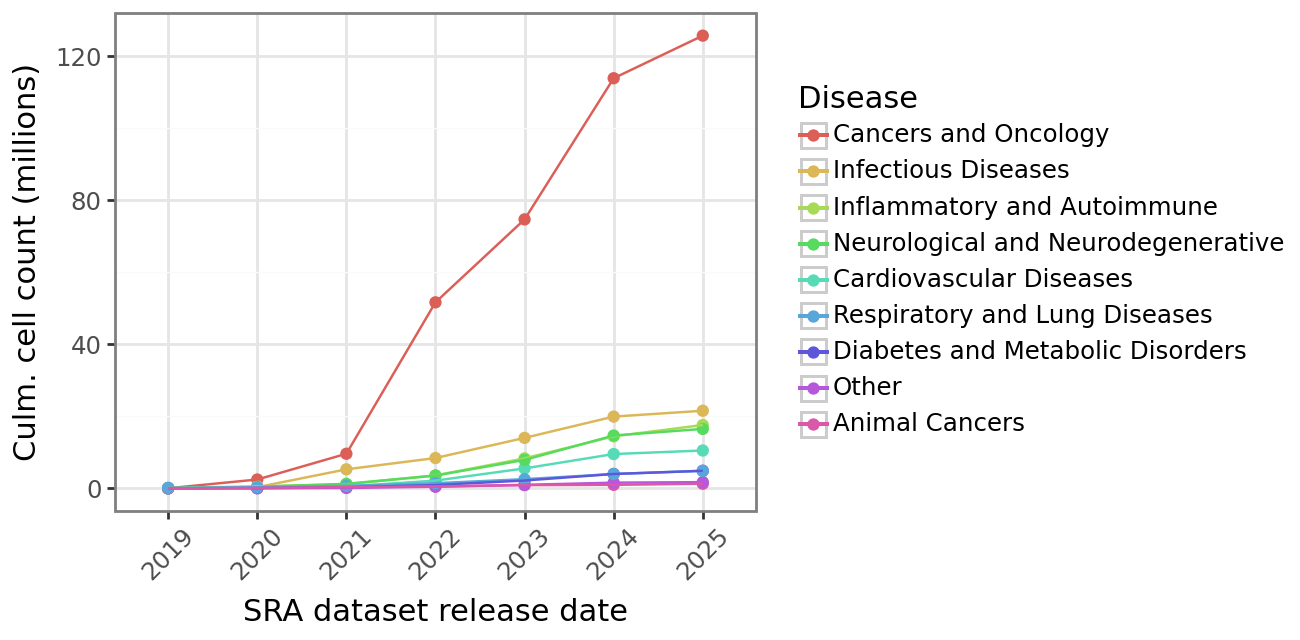

In [93]:
# filter to top 15 tissues
df_cells_disease_sum_top10 = (
    df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
    .groupby("disease_group").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(15)
    .reset_index()
)
df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# order by count
disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order)

# format
df["estimated_number_of_cells"] = df["estimated_number_of_cells"] / 1e6

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="disease_group")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="disease_group")) +
    #pn.facet_grid("organism ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Disease",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6.5, 3.2),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [94]:
# # save as svg
# outfile = base_dir / "figures" / "sra_cells-by-time_disease-mondo_hm.svg"
# pn.ggsave(p, outfile)
# print(f"File written to {outfile}")

In [95]:
# append row for total cell count
df_total = []
for release_date_year in df_cells_disease_sum["release_date_year"].unique():
    total_cells = df_cells_disease_sum[df_cells_disease_sum["release_date_year"] == release_date_year]["estimated_number_of_cells"].sum() / 1e6
    df_total.append({"release_date_year": release_date_year, "disease_group": "Total", "estimated_number_of_cells": total_cells})

df_total = pd.DataFrame(df_total)
df_j = pd.concat([df, df_total])
df_j

,estimated_number_of_cells,release_date_year,disease_group
5,0.000000,2019,Animal Cancers
0,0.029202,2019,Cancers and Oncology
...,...,...,...
5,182.964025,2024,Total
6,204.578209,2025,Total


In [96]:
# color dict
disease_colors = {
    "Total": "#000000",                               # Black (for future use)
    "Cancers and Oncology": "#F8766D",              # Red/salmon
    "Inflammatory and Autoimmune": "#D39200",        # Gold/dark yellow
    "Infectious Diseases": "#93AA00",                # Yellow-green/olive
    "Respiratory and Lung Diseases": "#00BA38",      # Green
    "Neurological and Neurodegenerative": "#00C19F", # Teal/cyan
    "Cardiovascular Diseases": "#00B9E3",            # Light blue
    "Diabetes and Metabolic Disorders": "#619CFF",   # Blue/purple
    "Animal Cancers": "#DB72FB",                     # Purple
    "Other": "#FF61C3",                              # Pink/magenta
    "Total": "#000000"                               # Black (for future use)
}

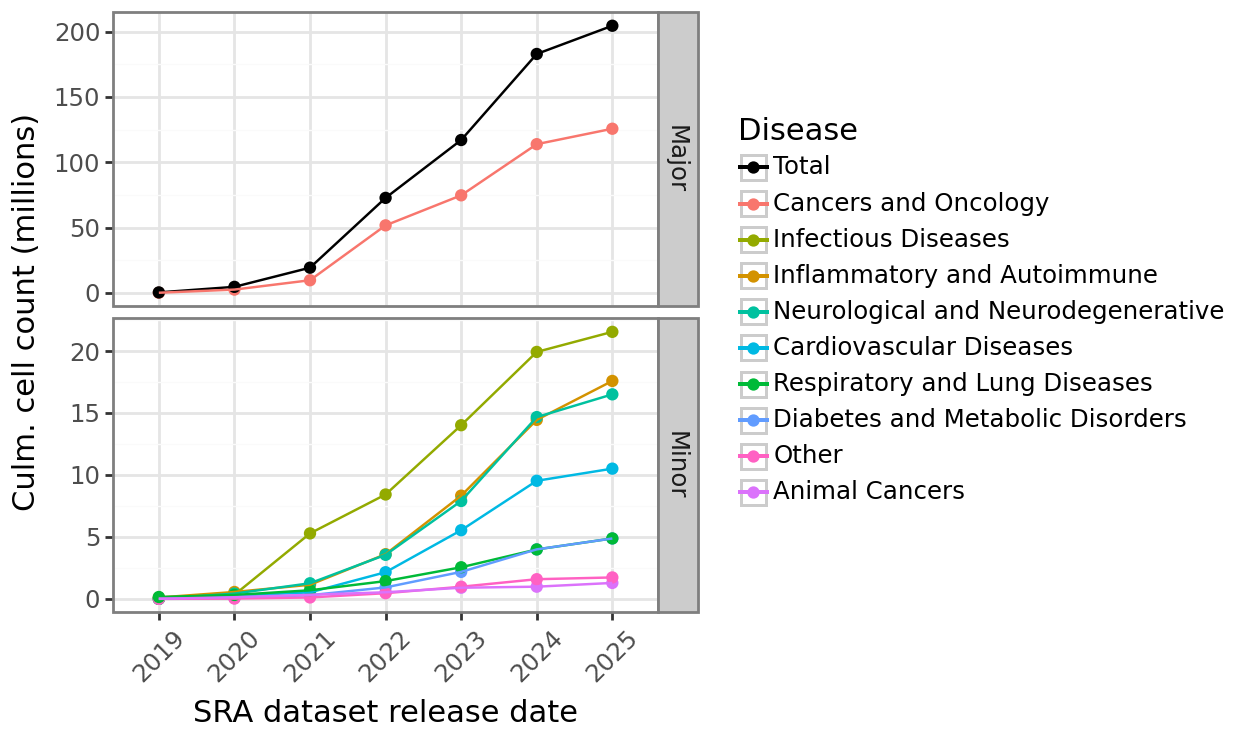

In [97]:
# a grouping columns: "Major" vs "Minor"
df_j["group"] = df_j["disease_group"].apply(lambda x: "Major" if x in ["Cancers and Oncology", "Total"] else "Minor")

# move "Total" to the of start the category for Disease
disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
disease_order.insert(0, "Total")
df_j["disease_group"] = pd.Categorical(df_j["disease_group"], categories=disease_order, ordered=True)

# plot the number of cells over time
p = (
    pn.ggplot(
        df_j, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", color="disease_group")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="disease_group")) +
    pn.scale_color_manual(values=disease_colors) + 
    #pn.scale_color_discrete() + 
    pn.facet_grid("group ~ .", scales="free_y") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Culm. cell count (millions)",
        color = "Disease",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6.2, 3.7),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11, 
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [32]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_disease-mondo_hm_total.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.2 x 3.7 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease-mondo_hm_total.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease-mondo_hm_total.svg


In [98]:
# save as csv
outfile = base_dir / "figures" / "data" / "sra_cells-by-time_disease-mondo_hm.csv"
df_j.to_csv(outfile, index=False)

### Specific stats

In [ ]:
# total `Cancers and Oncology`
total_cells = df_j[(df_j["release_date_year"] == "2025")]["estimated_number_of_cells"].sum()
cancer_cells = df_j[(df_j["disease_group"] == "Cancers and Oncology") & (df_j["release_date_year"] == "2025")]["estimated_number_of_cells"].sum()
cancer_cells / total_cells * 100

30.717087272965614

#### Disease rates

In [45]:
group_cols = ["release_date_year", "disease_group"]

In [46]:
# summarize cells by groups
df_cells_disease_sum = df_cells_disease.groupby(group_cols).agg({"estimated_number_of_cells": "sum"}).reset_index()
df_cells_disease_sum

,release_date_year,disease_group,estimated_number_of_cells
0,2019,Cancers and Oncology,29202
1,2019,Cardiovascular Diseases,4800
...,...,...,...
57,2025,Other,142190
58,2025,Respiratory and Lung Diseases,888368


In [47]:
# compete
df_cells_disease_sum = pandas_complete(
    df_cells_disease_sum, 
    group_cols=group_cols
)
df_cells_disease_sum

,release_date_year,disease_group,estimated_number_of_cells
0,2019,Cancers and Oncology,29202.0
1,2019,Cardiovascular Diseases,4800.0
...,...,...,...
61,2025,Neurological and Neurodegenerative,1835962.0
62,2025,Other,142190.0


In [48]:
# total sum scaling per year
df_total = df_cells_disease_sum.groupby("release_date_year").agg({"estimated_number_of_cells": "sum"}).reset_index().rename(columns={"estimated_number_of_cells" : "total_cell_count"})
df_cells_disease_sum = df_cells_disease_sum.merge(df_total, on="release_date_year", how="inner")
df_cells_disease_sum["estimated_number_of_cells"] = df_cells_disease_sum["estimated_number_of_cells"] / df_cells_disease_sum["total_cell_count"]
df_cells_disease_sum["estimated_number_of_cells"].describe()

count    63.000000
mean      0.111111
           ...    
75%       0.097690
max       0.785985
Name: estimated_number_of_cells, Length: 8, dtype: float64

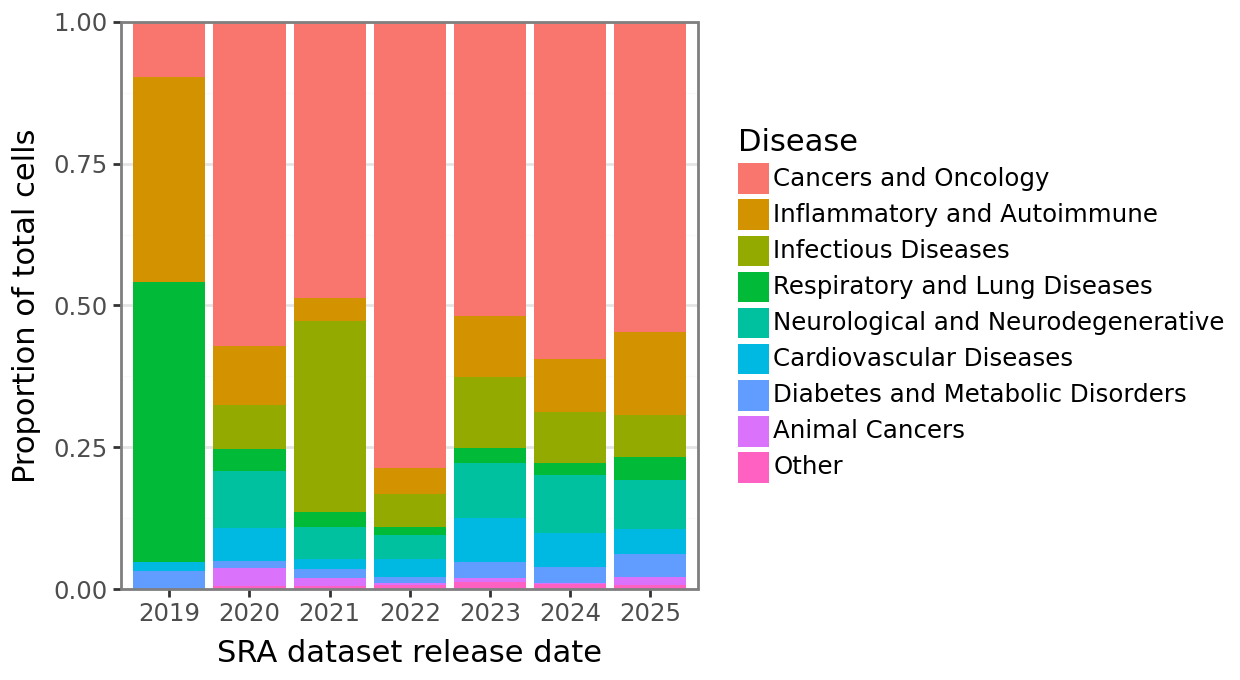

In [49]:
# plot the proportion of cells for each year
# filter to top 10 diseases
df_cells_disease_sum_top10 = (
    df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
    .groupby("disease_group").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(15)
    .reset_index()
)
df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# order by count
disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order)

# plot the proportion of cells for each year
p = (
    pn.ggplot(df, pn.aes(x="release_date_year", y="estimated_number_of_cells", fill="disease_group")) +
    pn.geom_col() +
    pn.scale_y_continuous(expand=(0, 0)) +
    pn.scale_fill_manual(values=disease_colors) + 
    pn.labs(
        x = "SRA dataset release date",
        y = "Proportion of total cells",
        fill = "Disease",
    ) +
    pn.theme(
        figure_size=(6.2, 3.4),
        legend_key_size=11
    )
)
p

In [50]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_disease-mondo_hm_all-years.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease-mondo_hm_all-years.svg


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.2 x 3.4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease-mondo_hm_all-years.svg


In [54]:
# infectious diseases
pd.set_option('display.max_rows', 10)
df_cells_disease_sum[(df_cells_disease_sum["disease_group"] == "Infectious Diseases")]

,release_date_year,disease_group,estimated_number_of_cells,total_cell_count
6,2019,Infectious Diseases,0.000000,299732.0
15,2020,Infectious Diseases,0.076928,4247511.0
24,2021,Infectious Diseases,0.337363,14686544.0
33,2022,Infectious Diseases,0.058706,53481112.0
42,2023,Infectious Diseases,0.126125,44328516.0
51,2024,Infectious Diseases,0.089708,65920610.0
60,2025,Infectious Diseases,0.074966,21614184.0


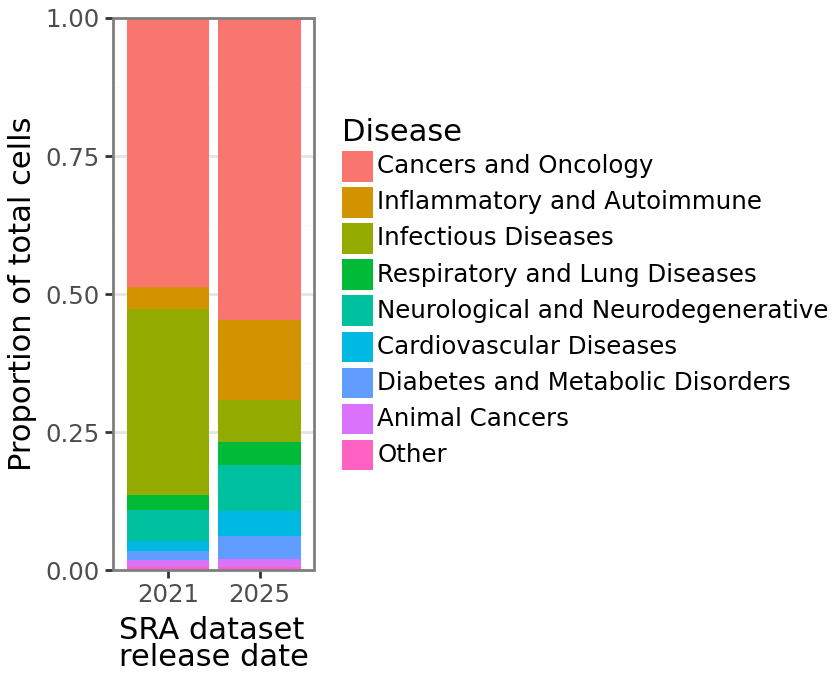

In [ ]:
# plot the proportion of cells for 2021 and 2025
pd.set_option('display.max_rows', 4)
# filter to top 10 diseases
df_cells_disease_sum_top10 = (
    df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
    .groupby("disease_group").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(15)
    .reset_index()
)
df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# order by count
disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order)

# filter to 2021 and 2025
x = pd.PeriodIndex(['2021', '2025'], freq='Y-DEC')
df_2022 = df[df["release_date_year"].isin(x)]

# plot the proportion of cells for 2021 and 2025
p = (
    pn.ggplot(df_2022, pn.aes(x="release_date_year", y="estimated_number_of_cells", fill="disease_group")) +
    pn.geom_col() +
    pn.scale_y_continuous(expand=(0, 0)) +
    pn.scale_fill_manual(values=disease_colors) + 
    pn.labs(
        x = "SRA dataset\nrelease date",
        y = "Proportion of total cells",
        fill = "Disease",
    ) +
    pn.theme(
        figure_size=(4.2, 3.4),
        legend_key_size=11
    )
)
p

In [130]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_disease-mondo_hm_2021-2025.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease-mondo_hm_2021-2025.svg


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4.2 x 3.4 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease-mondo_hm_2021-2025.svg


In [131]:
# calculate pct_change
df_cells_disease_sum['pct_change'] = (
    df_cells_disease_sum
    .sort_values(group_cols)  # Ensure proper ordering
    .groupby(group_cols[1:])['estimated_number_of_cells']
    .pct_change() * 100
)
x = pd.PeriodIndex(['2022', '2023', '2024', '2025'], freq='Y-DEC')
df_cells_disease_sum = df_cells_disease_sum[df_cells_disease_sum["release_date_year"].isin(x)]
df_cells_disease_sum["pct_change"].describe()

count     36.000000
mean      48.409945
            ...    
75%       82.280540
max      995.080576
Name: pct_change, Length: 8, dtype: float64

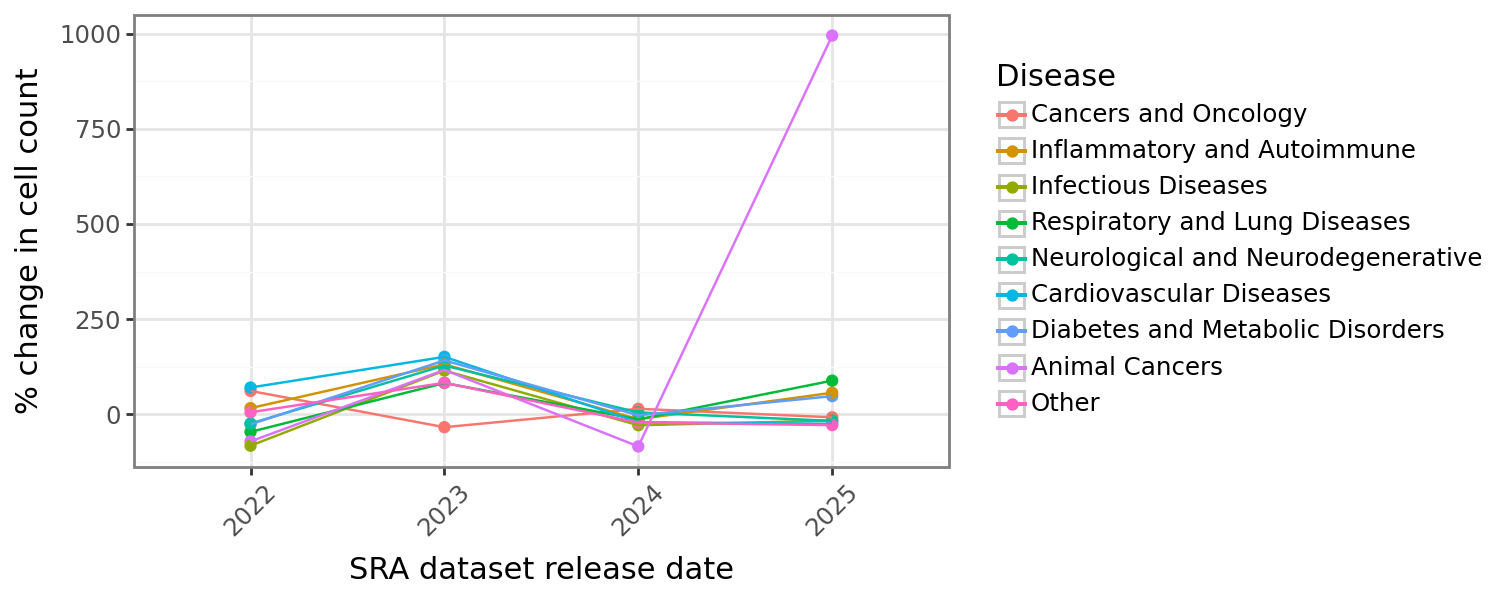

In [132]:
# filter to top 10 diseases
df_cells_disease_sum_top10 = (
    df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
    .groupby("disease_group").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(15)
    .reset_index()
)
df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# order by count
#disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order)

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="release_date_year", y="pct_change", color="disease_group")
    ) +
    pn.geom_point() +
    pn.geom_line(pn.aes(group="disease_group")) +
    pn.scale_color_manual(values=disease_colors) + 
    pn.labs(
        x = "SRA dataset release date",
        y = "% change in cell count",
        color = "Disease",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(7.5, 3),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

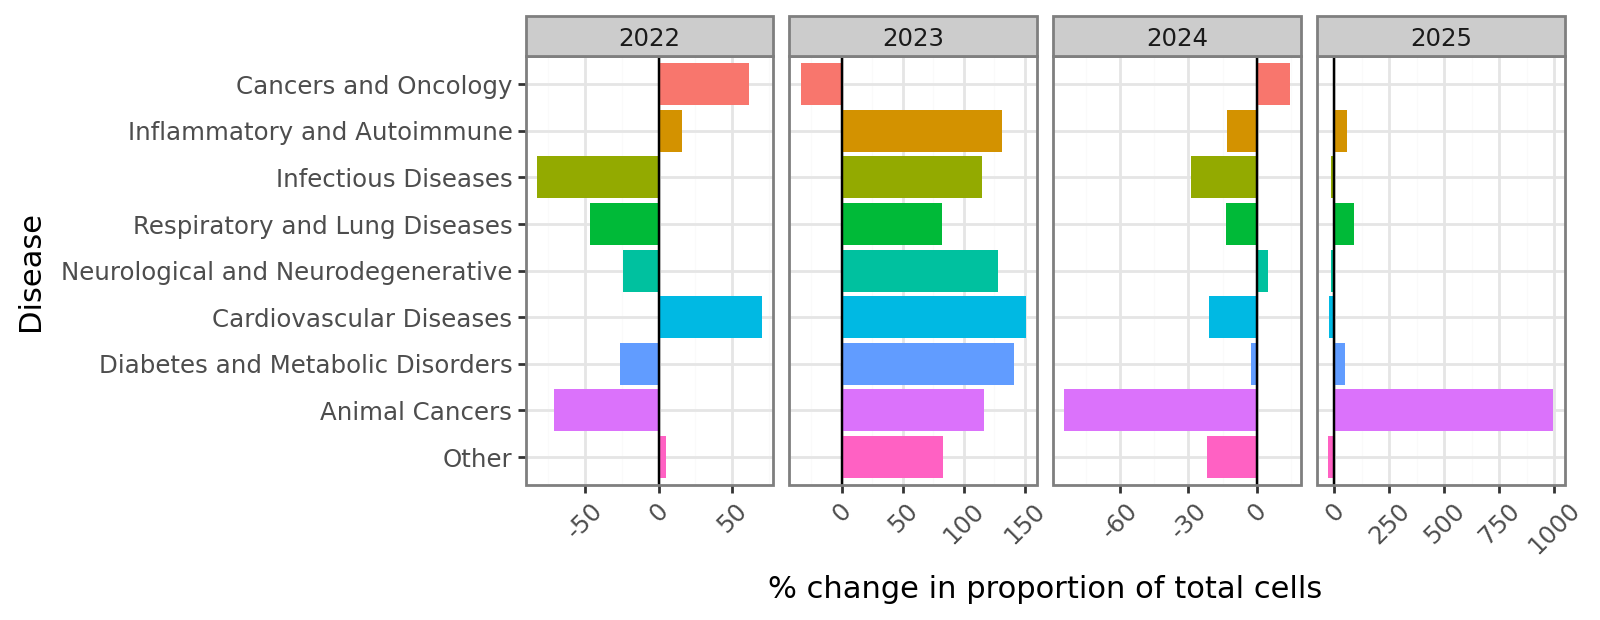

In [ ]:
# filter to top 10 diseases
df_cells_disease_sum_top10 = (
    df_cells_disease_sum[["disease_group", "estimated_number_of_cells"]][df_cells_disease_sum["disease_group"] != "other"]
    .groupby("disease_group").sum()
    .sort_values("estimated_number_of_cells", ascending=False)
    .head(15)
    .reset_index()
)
df = df_cells_disease_sum[df_cells_disease_sum["disease_group"].isin(df_cells_disease_sum_top10["disease_group"])]

# set color mapping
#color_mapping = dict(zip(disease_order, pn.scale_color_discrete().palette(len(disease_order))))

# order by count
#disease_order = df_cells_disease_sum_top10["disease_group"].unique().tolist()
df["disease_group"] = pd.Categorical(df["disease_group"], categories=disease_order[::-1])

# plot the number of cells over time
p = (
    pn.ggplot(
        df, 
        pn.aes(x="disease_group", y="pct_change", fill="disease_group")
    ) +
    pn.geom_col() +
    pn.geom_hline(pn.aes(yintercept=0), color="black") +
    pn.scale_fill_manual(values=disease_colors) +
    pn.facet_grid(". ~ release_date_year", scales="free_x") +
    pn.labs(
        x = "Disease",
        y = "% change in proportion of total cells",
        fill = "Direction",
    ) +
    pn.coord_flip() +
    pn.theme_bw() +
    pn.theme(
        figure_size=(8, 3.1),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=11,  # Reduce legend key size (default is around 20)
        legend_position="none",
    ) + 
    pn.guides(
        color=pn.guide_legend(ncol=1)
    )
)
p

In [134]:
# save as svg
outfile = base_dir / "figures" / "sra_cells-by-time_disease-mondo_hm_pct-change.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 3.1 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease-mondo_hm_pct-change.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_cells-by-time_disease-mondo_hm_pct-change.svg


## UMIs per cell

In [70]:
df_cells["median_umi_per_cell_norm"] = df_cells["median_umi_per_cell"] / df_cells["median_reads_per_cell"]
df_cells["median_umi_per_cell_norm"].describe()

count    61422.000000
mean         0.466722
             ...     
75%          0.689804
max          3.203809
Name: median_umi_per_cell_norm, Length: 8, dtype: float64

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


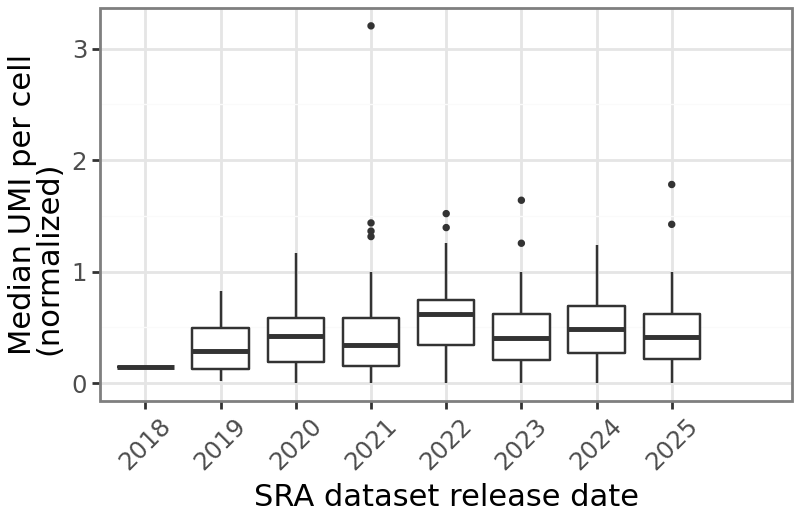

In [71]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells, 
        pn.aes(x="release_date_year", y="median_umi_per_cell_norm")
    ) +
    pn.geom_boxplot(outlier_size=0.5) +
    #pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median UMI per cell\n(normalized)",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(4, 2.6),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [72]:
# save as svg
outfile = base_dir / "figures" / "sra_umis-by-time.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4 x 2.6 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_umis-by-time.svg
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_umis-by-time.svg


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


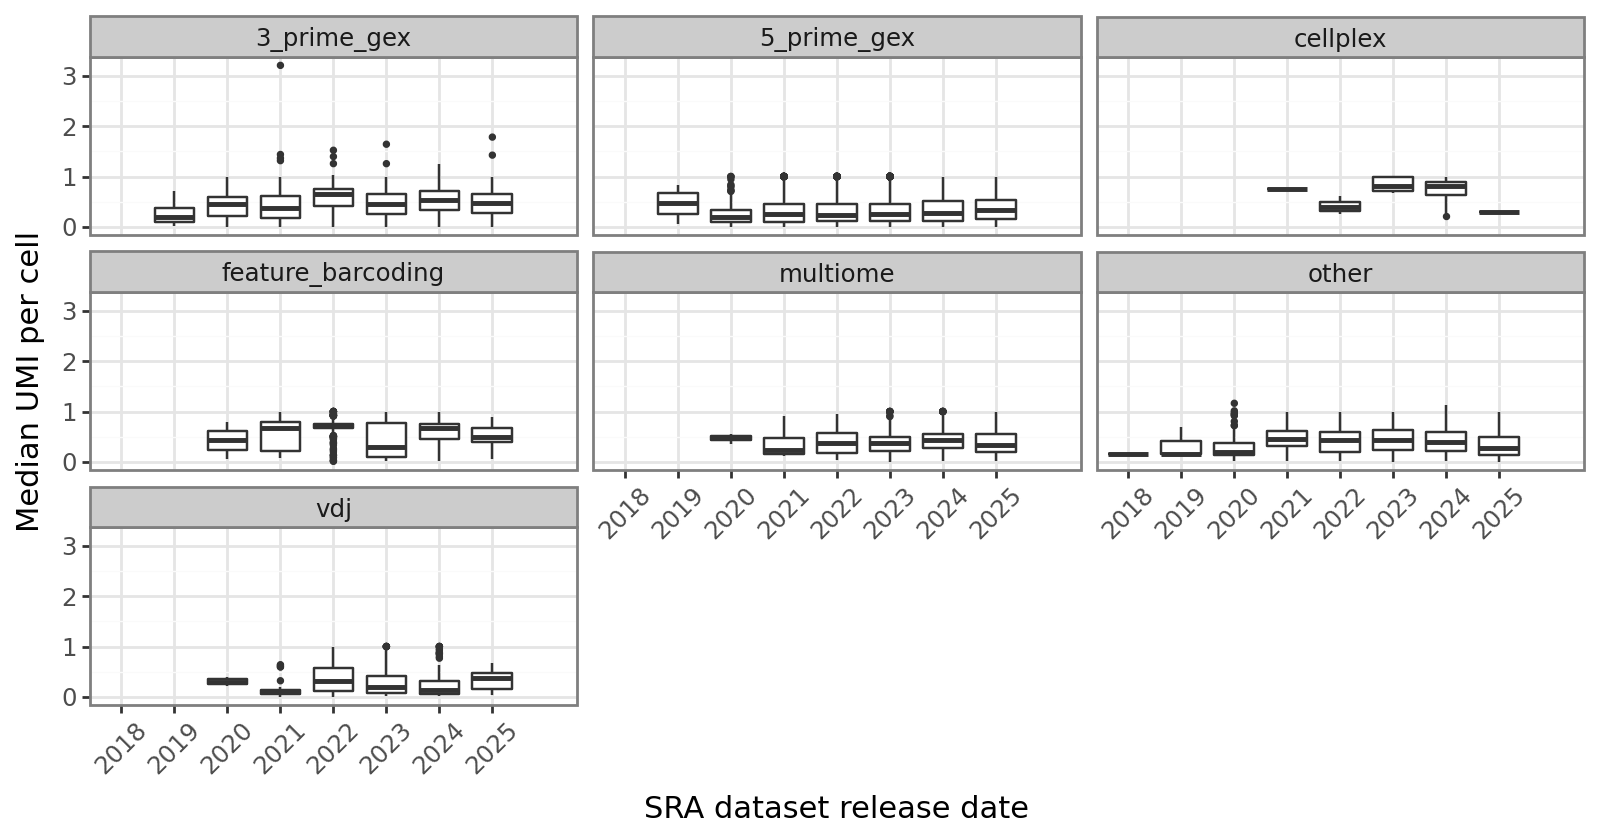

In [73]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells, 
        pn.aes(x="release_date_year", y="median_umi_per_cell_norm")
    ) +
    pn.geom_boxplot(outlier_size=0.5) +
    pn.facet_wrap("tech_10x") +
    #pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median UMI per cell",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(8, 4.2),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

#### UMIs by time and tech_10x

In [74]:
# aggregate by tech_10x and release data; calc mean and stdev
df_cells_sum = df_cells.groupby(["release_date_year", "tech_10x"]).agg({"median_umi_per_cell_norm": ["mean", "std"]}).reset_index()
df_cells_sum.columns = ["release_date_year", "tech_10x", "mean_umis", "std_umis"]

# fill in missing years
df_cells_sum = pandas_complete(
    df_cells_sum,
    group_cols=["release_date_year", "tech_10x"],
    fill_cols={"mean_umis": 0}
)
# convert NaN to 0
df_cells_sum = df_cells_sum.fillna(0)
df_cells_sum

,release_date_year,tech_10x,mean_umis,std_umis
0,2018,other,0.149192,0.000000
1,2018,3_prime_gex,0.000000,0.000000
...,...,...,...,...
54,2025,vdj,0.332247,0.187923
55,2025,cellplex,0.300459,0.015475


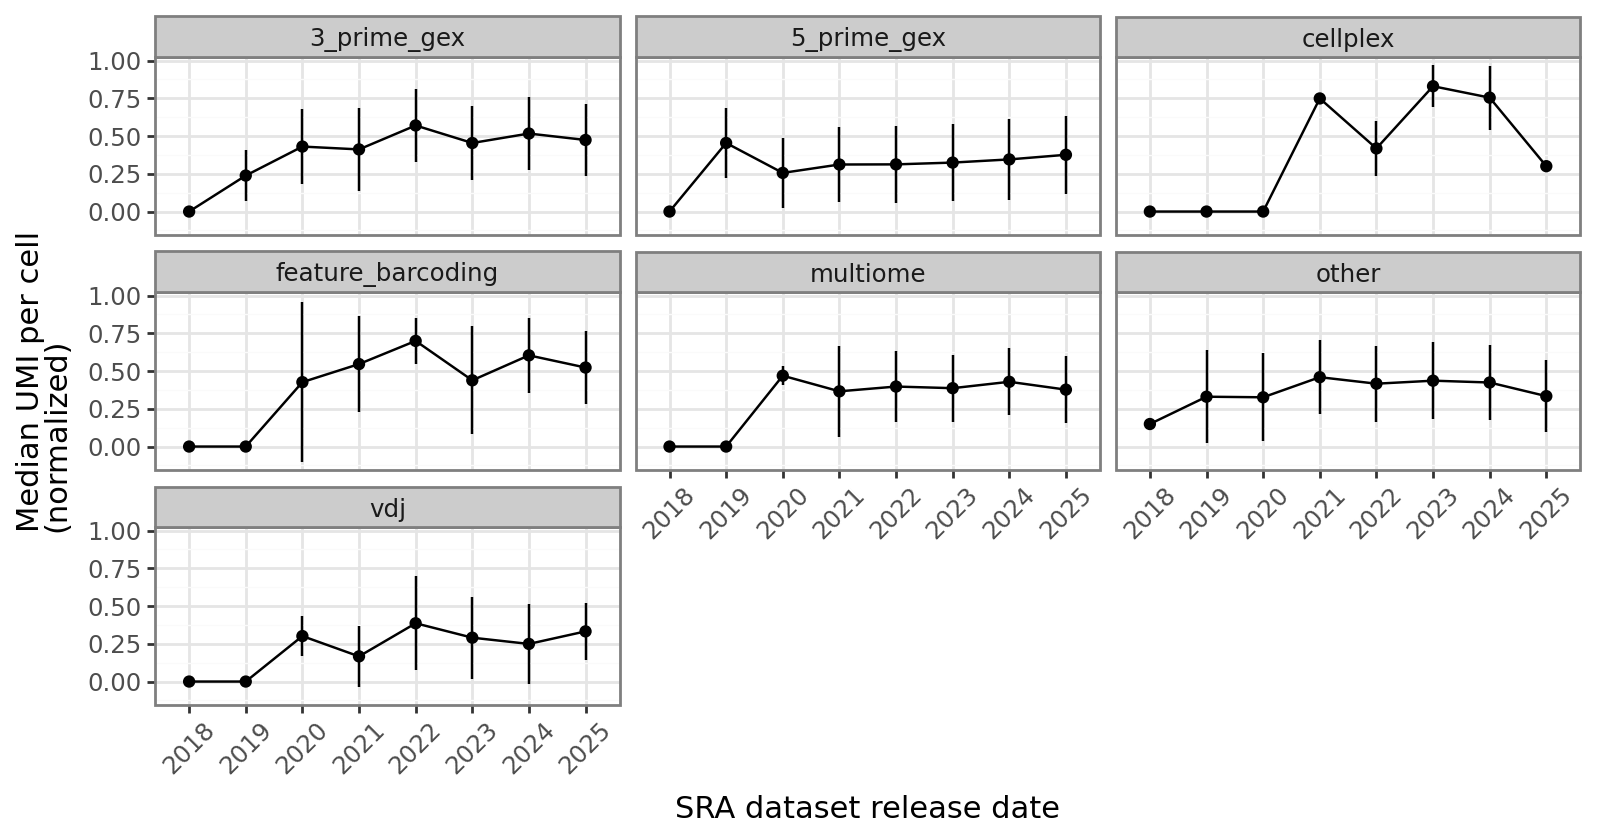

In [75]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells_sum, 
        pn.aes(x="release_date_year", y="mean_umis")
    ) +
    pn.geom_linerange(pn.aes(ymin="mean_umis - std_umis", ymax="mean_umis + std_umis")) +
    pn.geom_line(pn.aes(group="tech_10x")) +
    pn.geom_point() +
    pn.facet_wrap("tech_10x") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median UMI per cell\n(normalized)",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(8, 4.2),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [76]:
# save as svg
outfile = base_dir / "figures" / "sra_umis-by-time_tech10x.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4.2 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_umis-by-time_tech10x.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_umis-by-time_tech10x.svg


# Median genes per cell

In [85]:
df_cells["median_feature_per_cell_norm"] = df_cells["median_feature_per_cell"] / df_cells["median_reads_per_cell"]
df_cells["median_feature_per_cell_norm"].describe()

count    61422.000000
mean         0.231784
             ...     
75%          0.319630
max          1.000000
Name: median_feature_per_cell_norm, Length: 8, dtype: float64

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


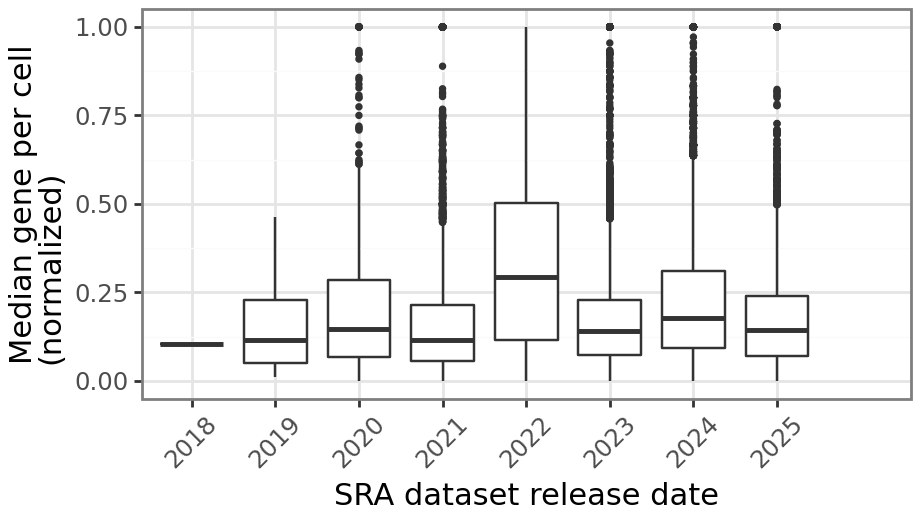

In [86]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells, 
        pn.aes(x="release_date_year", y="median_feature_per_cell_norm")
    ) +
    pn.geom_boxplot(outlier_size=0.5) +
    #pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median gene per cell\n(normalized)",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(4.6, 2.6),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [87]:
# save as svg
outfile = base_dir / "figures" / "sra_genes-by-time.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4.6 x 2.6 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_genes-by-time.svg
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_genes-by-time.svg


## Reads per cell

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


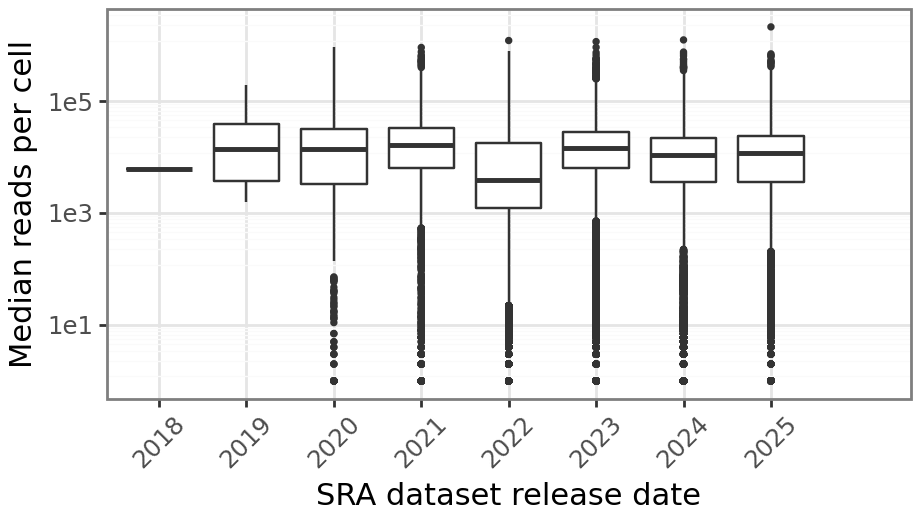

In [80]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells, 
        pn.aes(x="release_date_year", y="median_reads_per_cell")
    ) +
    pn.geom_boxplot(outlier_size=0.5) +
    pn.scale_y_log10() +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median reads per cell",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(4.6, 2.6),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [81]:
# save as svg
outfile = base_dir / "figures" / "sra_reads-by-time.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 4.6 x 2.6 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_reads-by-time.svg
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 818 rows containing non-finite values.


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_reads-by-time.svg


#### By time and tech_10x

In [82]:
# aggregate by tech_10x and release data; calc mean and stdev
df_cells_sum = df_cells.groupby(["release_date_year", "tech_10x"]).agg({"median_reads_per_cell": ["mean", "std"]}).reset_index()
df_cells_sum.columns = ["release_date_year", "tech_10x", "mean_reads", "std_reads"]

# fill in missing years
df_cells_sum = pandas_complete(
    df_cells_sum,
    group_cols=["release_date_year", "tech_10x"],
    fill_cols={"mean_reads": 0}
)
# convert NaN to 0
df_cells_sum = df_cells_sum.fillna(0)
df_cells_sum

,release_date_year,tech_10x,mean_reads,std_reads
0,2018,other,6066.000000,0.000000
1,2018,3_prime_gex,0.000000,0.000000
...,...,...,...,...
54,2025,vdj,13886.431034,22763.262661
55,2025,cellplex,32371.000000,1787.565943


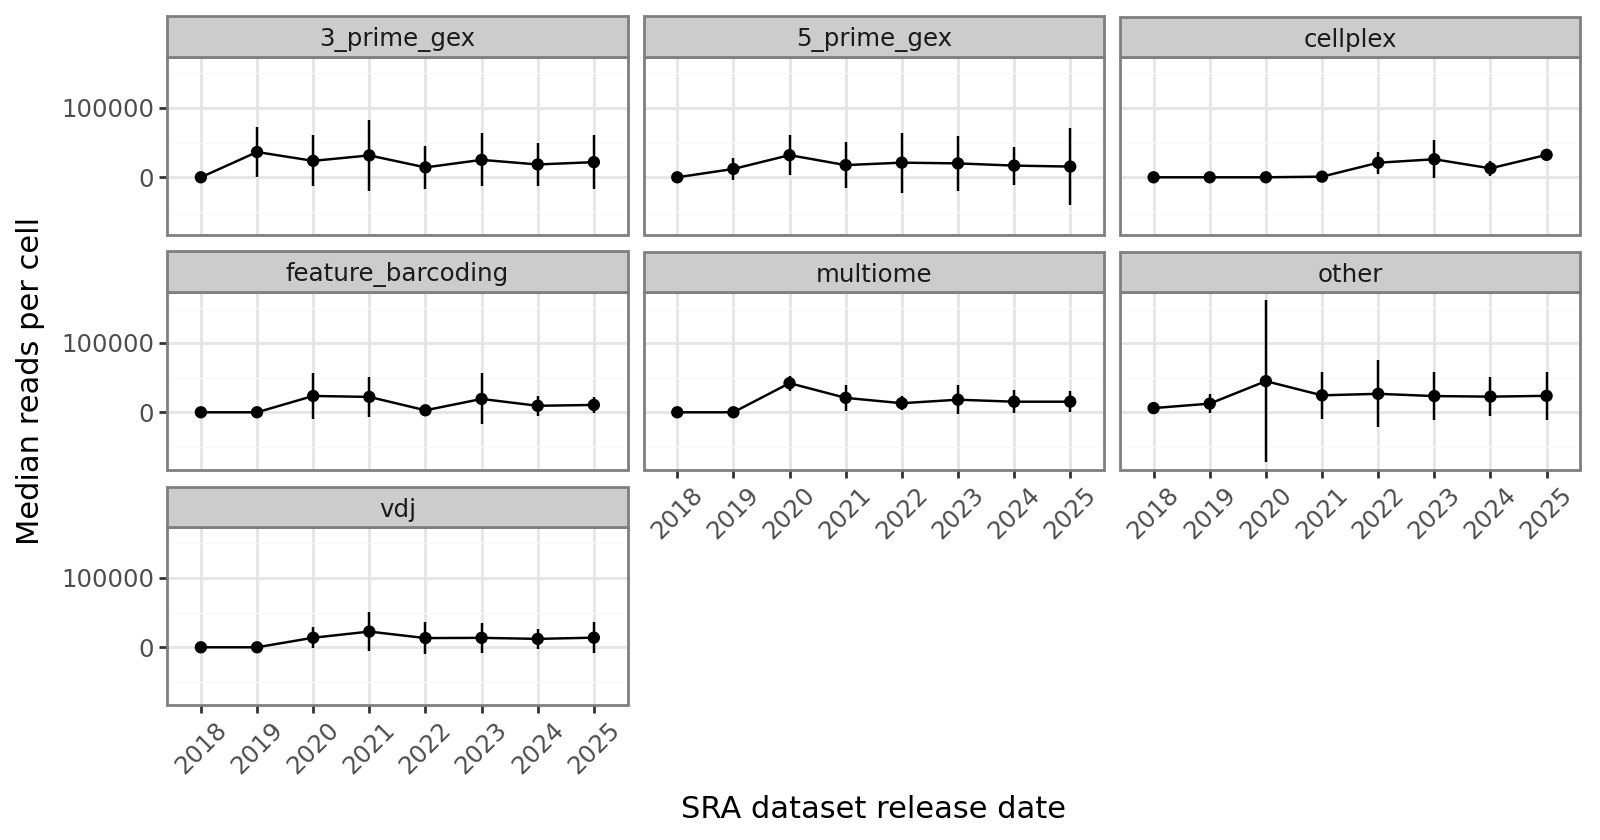

In [83]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells_sum, 
        pn.aes(x="release_date_year", y="mean_reads")
    ) +
    pn.geom_linerange(pn.aes(ymin="mean_reads - std_reads", ymax="mean_reads + std_reads")) +
    pn.geom_line(pn.aes(group="tech_10x")) +
    pn.geom_point() +
    pn.facet_wrap("tech_10x") +
    pn.labs(
        x = "SRA dataset release date",
        y = "Median reads per cell",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(8, 4.2),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
        legend_key_size=12,  # Reduce legend key size (default is around 20)
    )
)
p

In [84]:
# save as svg
outfile = base_dir / "figures" / "sra_reads-by-time_tech10x.svg"
pn.ggsave(p, outfile)
print(f"File written to {outfile}")

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4.2 in image.
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_reads-by-time_tech10x.svg


File written to /home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sra_reads-by-time_tech10x.svg


# --OLD--

### Cells by month

In [ ]:
# summarize cells by month and tech_10x
df_cells_sum = df_cells.groupby(["release_date_month", "tech_10x", "organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
# filter
df_cells_sum = df_cells_sum[df_cells_sum["organism"].isin(["Homo sapiens", "Mus musculus"])]
# if tech_10x == "not_applicable", set to "other"
df_cells_sum["tech_10x"] = df_cells_sum["tech_10x"].apply(lambda x: "other" if x == "not_applicable" else x)
df_cells_sum

In [ ]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells_sum, 
        pn.aes(x="release_date_month", y="estimated_number_of_cells", fill="organism")
    ) +
    pn.geom_col() +
    pn.scale_y_log10() +
    pn.facet_wrap("~tech_10x", ncol=2) +
    pn.labs(
        x = "SRA dataset release date",
        y = "Estimated Number of Cells",
        fill = "Organism",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(14, 10),
        axis_text_x=pn.element_text(angle=90, hjust=0.9, size=7),
    )
)
p